In [1]:
# https://pypi.org/project/PuLP/
# https://coin-or.github.io/pulp/guides/index.html

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sqlite3 import connect
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 50)

In [6]:
pd.options.display.float_format = "{:.2f}".format

In [7]:
# Get the absolute path of the file within the INPUTS directory
file_path = os.path.join(os.getcwd(), 'INPUTS', 'case_study_data.csv')

# Print the file path
print(file_path)

C:\Users\KonuTech\PycharmProjects\supply-chain-case-study\INPUTS\case_study_data.csv


In [8]:
# Get the absolute path of the config within the CONFIGS directory
config_path = os.path.join(os.getcwd(), 'CONFIGS', 'config.json')

# Print the fileconfig_pathpath
print(config_path)

C:\Users\KonuTech\PycharmProjects\supply-chain-case-study\CONFIGS\config.json


In [9]:
with open(config_path, encoding='utf-8') as f:
    CONFIG = json.load(f)

In [10]:
INDEX_COL = CONFIG["INPUTS"]["INDEX_COLUMNS"]
SEP = CONFIG["INPUTS"]["SEPARATOR"]
DECIMAL = CONFIG["INPUTS"]["DECIMAL"]
ENCODING = CONFIG["INPUTS"]["ENCODING"]
DATE_COLUMNS = CONFIG["INPUTS"]["DATE_COLUMNS"]
FLOAT_PRECISION = CONFIG["INPUTS"]["FLOAT_PRECISION"]
DTYPE = CONFIG["INPUTS"]["DTYPE"]
COLUMNS_WITH_NAN_VALUES = CONFIG["INPUTS"]["COLUMNS_WITH_NAN_VALUES"]
X_ORDER = CONFIG["X_ORDER"]
HUE_ORDER = CONFIG["HUE_ORDER"]
COL_ORDER = CONFIG["COL_ORDER"]

In [11]:
df = pd.read_csv(
    file_path,
#     index_col=INDEX_COL,
    sep=SEP,
    encoding=ENCODING,
    engine="c",
    low_memory=False,
#     parse_dates=DATE_COLUMNS,
    dtype=DTYPE
)

In [12]:
print(df.index.duplicated())

[False False False ... False False False]


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9993 entries, 0 to 9992
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order ID      9993 non-null   object 
 1   Order Date    9993 non-null   object 
 2   Ship Mode     9993 non-null   object 
 3   Region        9993 non-null   object 
 4   Product ID    9993 non-null   object 
 5   Category      9993 non-null   object 
 6   Sub-Category  9993 non-null   object 
 7   Product Name  9993 non-null   object 
 8   Sales         9993 non-null   float64
 9   Quantity      9993 non-null   int64  
 10  Discount      9993 non-null   float64
 11  Profit        8000 non-null   float64
dtypes: float64(3), int64(1), object(8)
memory usage: 937.0+ KB


# PREPROCESSING

In [14]:
# df.index = pd.to_datetime(df["Order Date"])

In [15]:
# Use regex to separate the string parts of the Order ID column into separate fields
df[['Order ID prefix', 'Order ID year', 'Order ID number']] = df['Order ID'].str.extract(r'(\w+)-(\d+)-(\d+)')

# Use regex to separate the string parts of the Order Date column into separate fields
df[['Order Year', 'Order Month', 'Order Day']] = pd.to_datetime(df['Order Date']).dt.strftime('%Y-%m-%d').str.extract(r'(\d{4})-(\d{2})-(\d{2})')

In [16]:
# Normalize Profit column as new column
df['Normalized Profit'] = (df['Profit'] - df['Profit'].mean()) / df['Profit'].std()

In [17]:
# Normalize Sales column as new column
df['Normalized Sales'] = (df['Sales'] - df['Sales'].mean()) / df['Sales'].std()

In [18]:
# Standardize Profit column as new column
mean_profit = df['Profit'].mean()
std_profit = df['Profit'].std()
df['Standardized Profit'] = (df['Profit'] - mean_profit) / std_profit

In [19]:
# Standardize Sales column as new column
mean_sales = df['Sales'].mean()
std_sales = df['Sales'].std()
df['Standardized Sales'] = (df['Sales'] - mean_sales) / std_sales

In [20]:
df['Winsorized Sales'] = stats.mstats.winsorize(df['Sales'], limits=[0.05, 0.05])

In [21]:
df['Winsorized Profit'] = stats.mstats.winsorize(df['Profit'], limits=[0.10, 0.10])

In [22]:
# Use RobustScaler to scale Sales using IQR method as new column
scaler = RobustScaler()
df['Scaled Sales'] = scaler.fit_transform(df[['Sales']])
df['Scaled Profit'] = scaler.fit_transform(df[['Profit']])

In [23]:
# Create a FunctionTransformer object with a logarithmic transformation function
# log_transformer = FunctionTransformer(np.log1p)
log_transformer = FunctionTransformer(np.log10)

# Apply the logarithmic transformation to the "Sales" column
df['Log Sales'] = log_transformer.transform(df[['Sales']])
df['Log Profit'] = log_transformer.transform(df[['Profit']])

In [24]:
df["Category-SubCategory"] = df["Category"].str.cat(df["Sub-Category"], sep="-")

In [25]:
df_sample = df.sample(n=3000)
df_sample

Order ID  Order Date       Ship Mode   Region       Product ID  \
4544  PL-2017-101042  2017-11-19  Standard Class    South  FUR-FU-10004665   
8458  PL-2015-114503  2015-11-13  Standard Class    South  OFF-ST-10003572   
8546  PL-2014-137092  2014-10-20    Second Class  Central  TEC-AC-10001606   
9100  PL-2016-109666  2016-04-19  Standard Class     East  TEC-PH-10004774   
1648  PL-2016-107104  2016-11-26  Standard Class     West  FUR-BO-10002213   
6042  PL-2017-136350  2017-06-24    Second Class     East  FUR-FU-10003601   
3735  PL-2017-152807  2017-10-30  Standard Class     East  FUR-FU-10004415   
9065  PL-2016-112256  2016-07-23  Standard Class  Central  OFF-PA-10004355   
8069  PL-2016-151561  2016-09-01  Standard Class     East  TEC-AC-10001432   
971   SL-2014-149034  2014-11-19     First Class     East  TEC-AC-10003023   
3155  PL-2014-127964  2014-03-03  Standard Class     East  TEC-PH-10004700   
9521  SL-2017-106145  2017-09-26        Same Day     West  OFF-PA-10002245   
8327  PL-2014-133305  2014-07-11  Standard Class     East  OFF-PA-10001970   
7952  PL-2016-127138  2016-03-12    Second Class     West  FUR-CH-10003746   
5850  SL-2017-105389  2017-10-23    Second Class  Central  OFF-AR-10000634   
6867  PL-2017-164042  2017-05-23  Standard Class  Central  OFF-BI-10001922   
811   SL-2016-140172  2016-03-08  Standard Class  Central  OFF-AR-10002766   
4853  PL-2017-138975  2017-05-19  Standard Class    South  FUR-BO-10004695   
6526  PL-2014-140403  2014-10-10        Same Day     West  OFF-EN-10001219   
3208  SL-2017-118087  2017-09-09  Standard Class     East  OFF-AR-10003602   
4492  SL-2017-133781  2017-06-22     First Class    South  OFF-EN-10004483   
4123  SL-2014-114188  2014-05-20    Second Class     East  OFF-AR-10004511   
8613  SL-2017-167402  2017-01-13    Second Class  Central  OFF-SU-10002881   
3871  PL-2017-118885  2017-12-29  Standard Class     West  TEC-PH-10002563   
6364  SL-2016-165078  2016-11-05  Standard Class  Central  OFF-LA-10000414   
...              ...         ...             ...      ...              ...   
357   PL-2014-110555  2014-04-11  Standard Class     West  TEC-PH-10000586   
4239  PL-2017-103380  2017-11-21  Standard Class     West  TEC-PH-10004165   
5110  PL-2016-150350  2016-08-23  Standard Class     West  OFF-SU-10002189   
9000  PL-2015-154823  2015-08-21  Standard Class     East  OFF-BI-10001098   
2983  PL-2015-153549  2015-03-29    Second Class    South  FUR-CH-10004086   
6475  PL-2016-109365  2016-11-03  Standard Class     West  OFF-BI-10003981   
5266  PL-2017-133865  2017-05-08  Standard Class     West  TEC-CO-10001046   
8494  PL-2014-129147  2014-11-02  Standard Class     East  TEC-PH-10001299   
5993  PL-2014-116834  2014-10-11  Standard Class     West  FUR-FU-10001196   
5218  PL-2014-108189  2014-10-02     First Class     West  OFF-EN-10004846   
8386  PL-2016-129126  2016-12-14  Standard Class     East  OFF-FA-10000621   
5890  PL-2017-134285  2017-12-07  Standard Class  Central  OFF-PA-10000304   
6400  PL-2016-100041  2016-11-20  Standard Class  Central  OFF-PA-10000418   
7588  PL-2017-160325  2017-09-24        Same Day     East  TEC-PH-10001944   
4168  PL-2016-125738  2016-10-15  Standard Class     West  OFF-PA-10000740   
6941  PL-2017-107125  2017-11-27  Standard Class     West  OFF-BI-10001989   
5900  PL-2015-167010  2015-04-05  Standard Class     East  TEC-PH-10000347   
3832  PL-2014-117345  2014-08-01  Standard Class    South  OFF-AP-10001005   
7543  SL-2014-159618  2014-11-12  Standard Class  Central  OFF-AR-10003183   
420   PL-2017-150091  2017-10-12  Standard Class     East  TEC-AC-10002167   
9837  SL-2017-123834  2017-07-21  Standard Class  Central  FUR-TA-10001676   
8515  PL-2017-138289  2017-01-16    Second Class  Central  OFF-PA-10001260   
6617  PL-2017-147228  2017-09-09  Standard Class    South  OFF-ST-10000046   
7235  PL-2017-146367  2017-08-04  Standard Class  Central  OFF-BI-10002827   
4122  SL-2014-114188  2014-05-20  

# HISTOGRAMS

## Sales

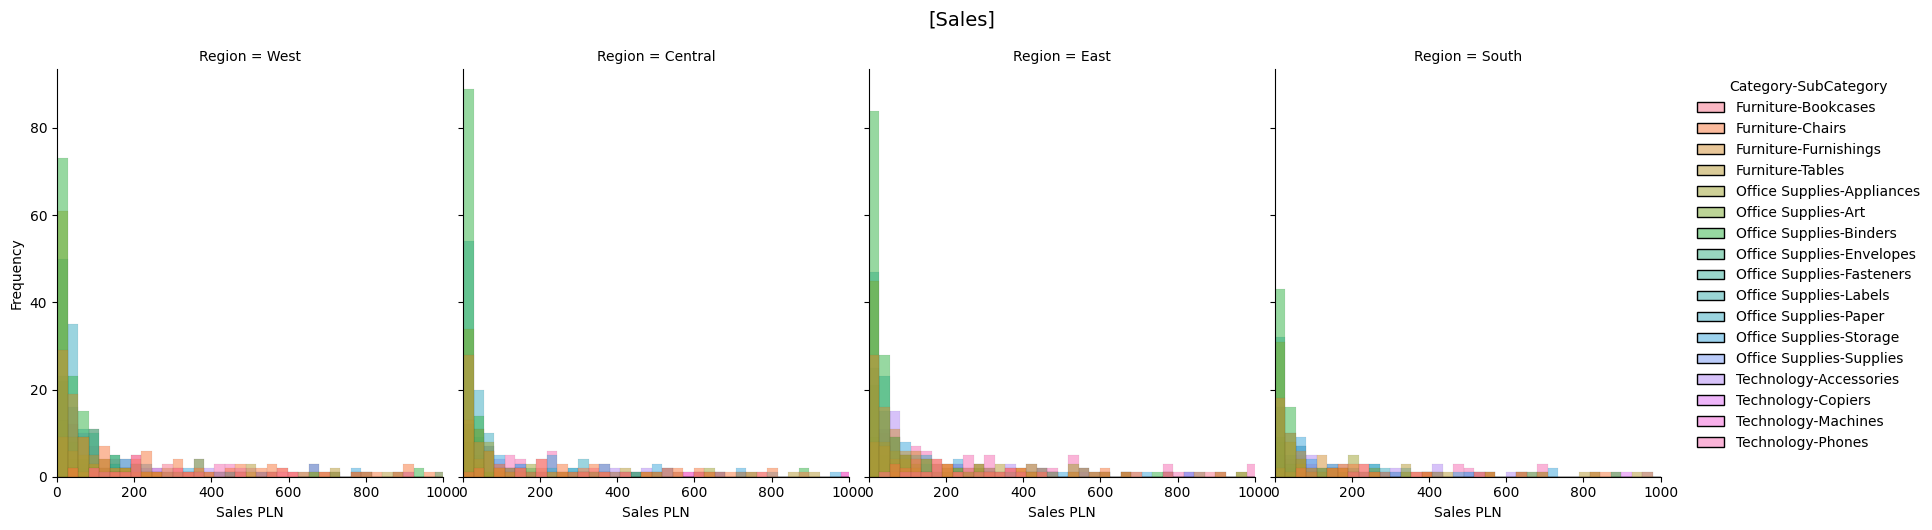

In [26]:
# Create a histogram with groupings based on Order Year
g = sns.displot(data=df_sample,
                x="Sales", hue="Category-SubCategory", kde=False, hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85)

# Customize the plot
g.set(xlim=(0, 1000), xlabel="Sales PLN", ylabel="Frequency")
g.fig.suptitle(f"[Sales]", fontsize=14, y=1.05)
# Show the plot
plt.show()

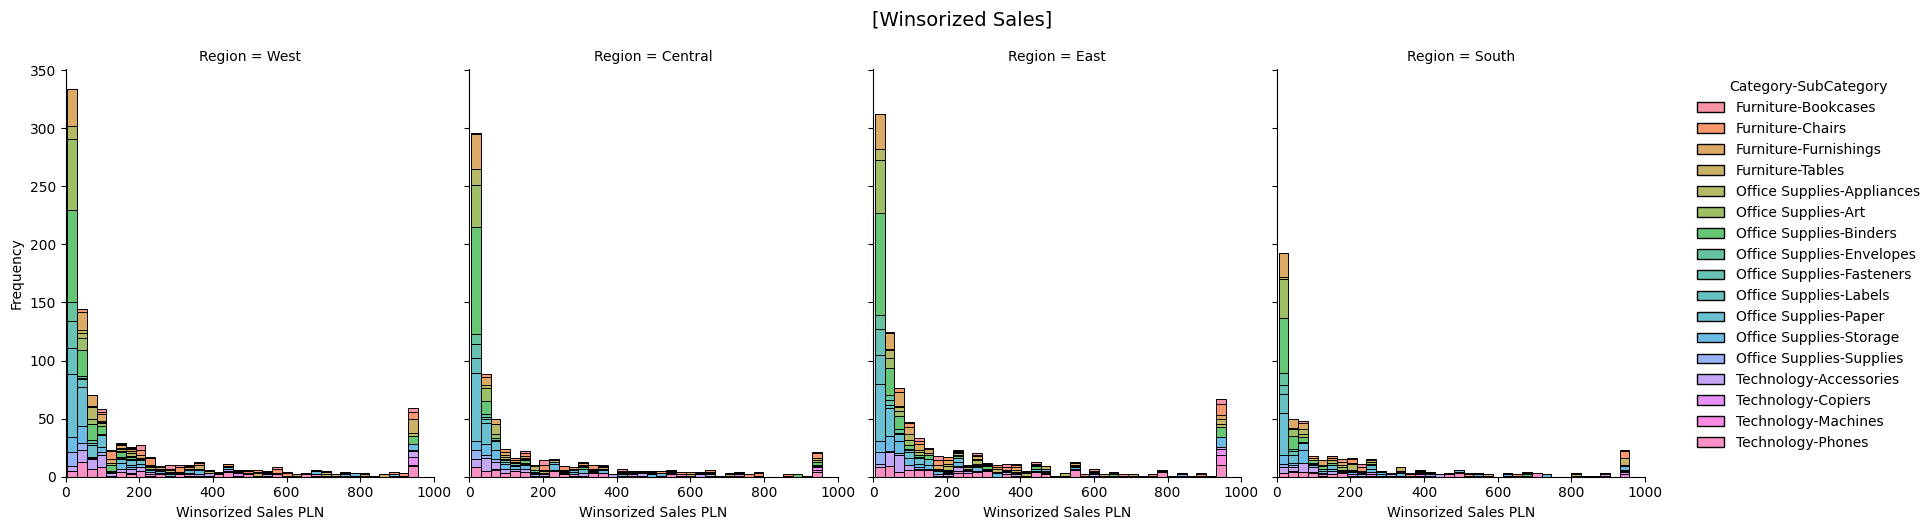

In [27]:
# Create a histogram with groupings based on Order Year
g = sns.displot(data=df_sample,
                x="Winsorized Sales", hue="Category-SubCategory", multiple="stack", kde=False, hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85)

# Customize the plot
g.set(xlim=(0, 1000), xlabel="Winsorized Sales PLN", ylabel="Frequency")
g.fig.suptitle(f"[Winsorized Sales]", fontsize=14, y=1.05)
# Show the plot
plt.show()

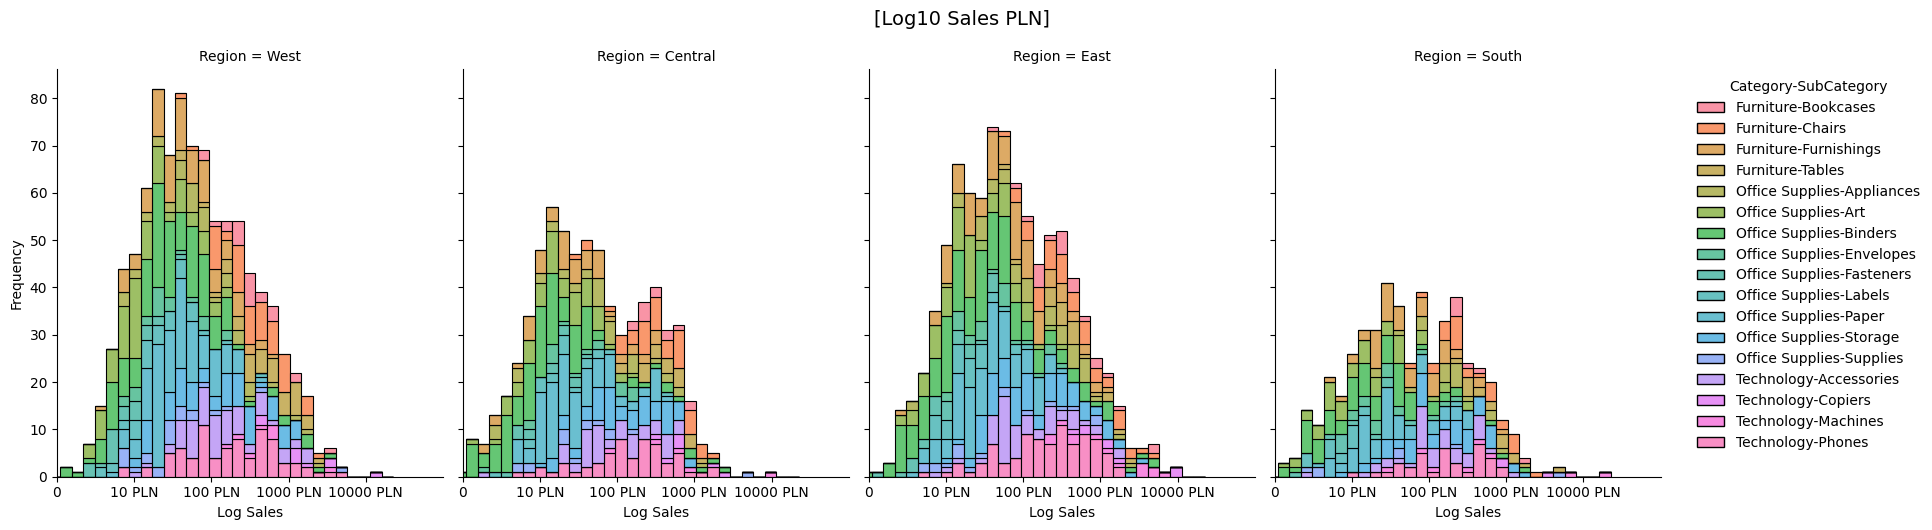

In [28]:
# Create a histogram with groupings based on Order Year
g = sns.displot(data=df_sample,
                x="Log Sales", hue="Category-SubCategory", multiple="stack", kde=False, hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85)

# Customize the plot
g.set(xlim=(0, 5), xlabel="Log Sales", ylabel="Frequency")
g.fig.suptitle(f"[Log10 Sales PLN]", fontsize=14, y=1.05)

# Set the x-axis ticks to [0, 10, 100, 1000]
g.set(xticks=[0, 1, 2, 3, 4], xticklabels=["0", "10 PLN", "100 PLN", "1000 PLN", "10000 PLN"])
# g.axes[0][0].xaxis.set_major_formatter(ticker.ScalarFormatter())

# Show the plot
plt.show()

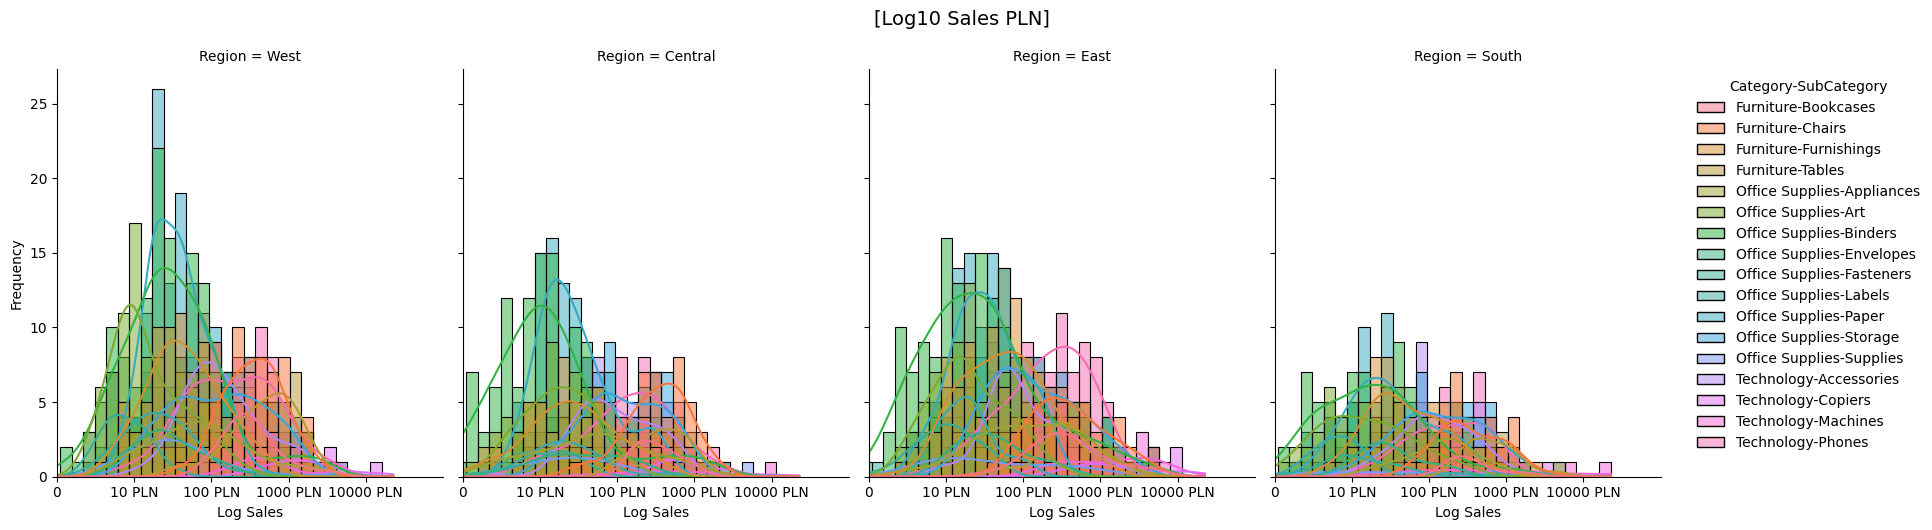

In [29]:
# Create a histogram with groupings based on Order Year
g = sns.displot(data=df_sample,
                x="Log Sales", hue="Category-SubCategory", kde=True, hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85)

# Customize the plot
g.set(xlim=(0, 5), xlabel="Log Sales", ylabel="Frequency")
g.fig.suptitle(f"[Log10 Sales PLN]", fontsize=14, y=1.05)

# Set the x-axis ticks to [0, 10, 100, 1000]
g.set(xticks=[0, 1, 2, 3, 4], xticklabels=["0", "10 PLN", "100 PLN", "1000 PLN", "10000 PLN"])
# g.axes[0][0].xaxis.set_major_formatter(ticker.ScalarFormatter())

# Show the plot
plt.show()

0 Furniture-Furnishings


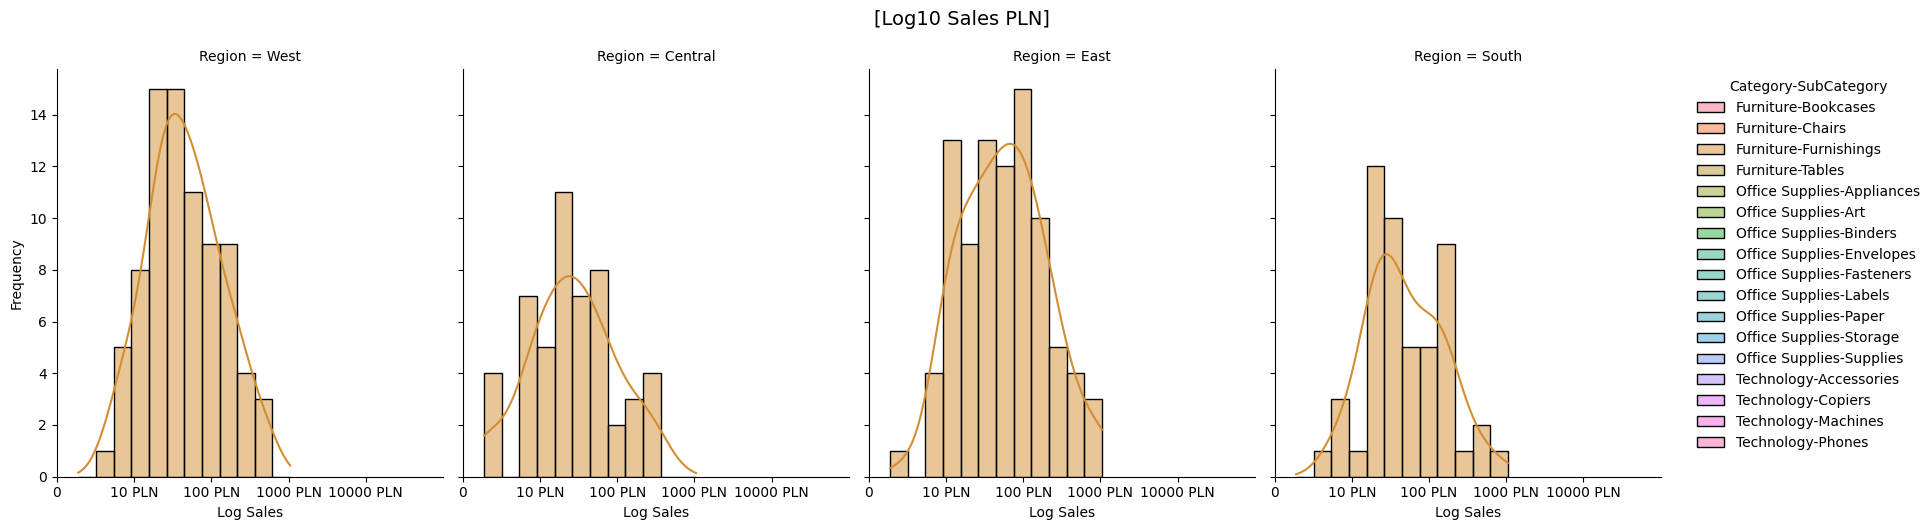

1 Office Supplies-Storage


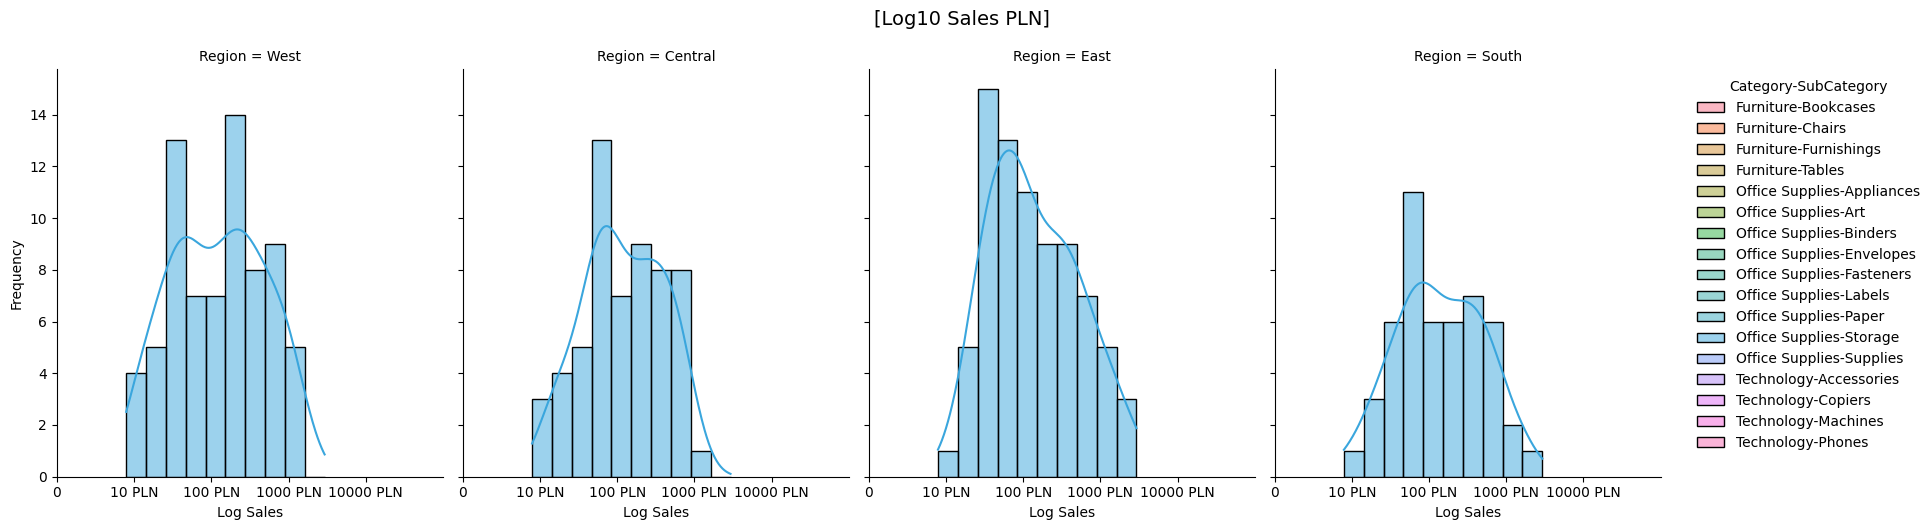

2 Technology-Accessories


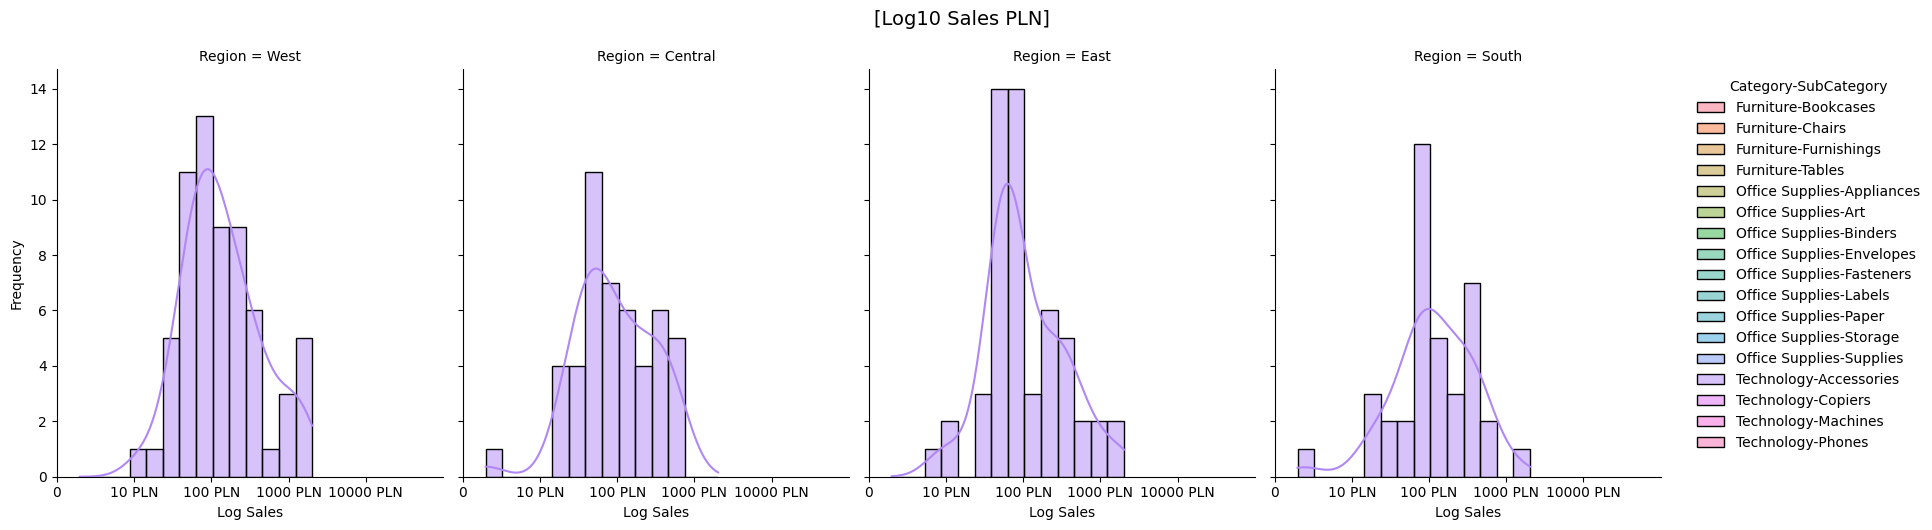

3 Technology-Phones


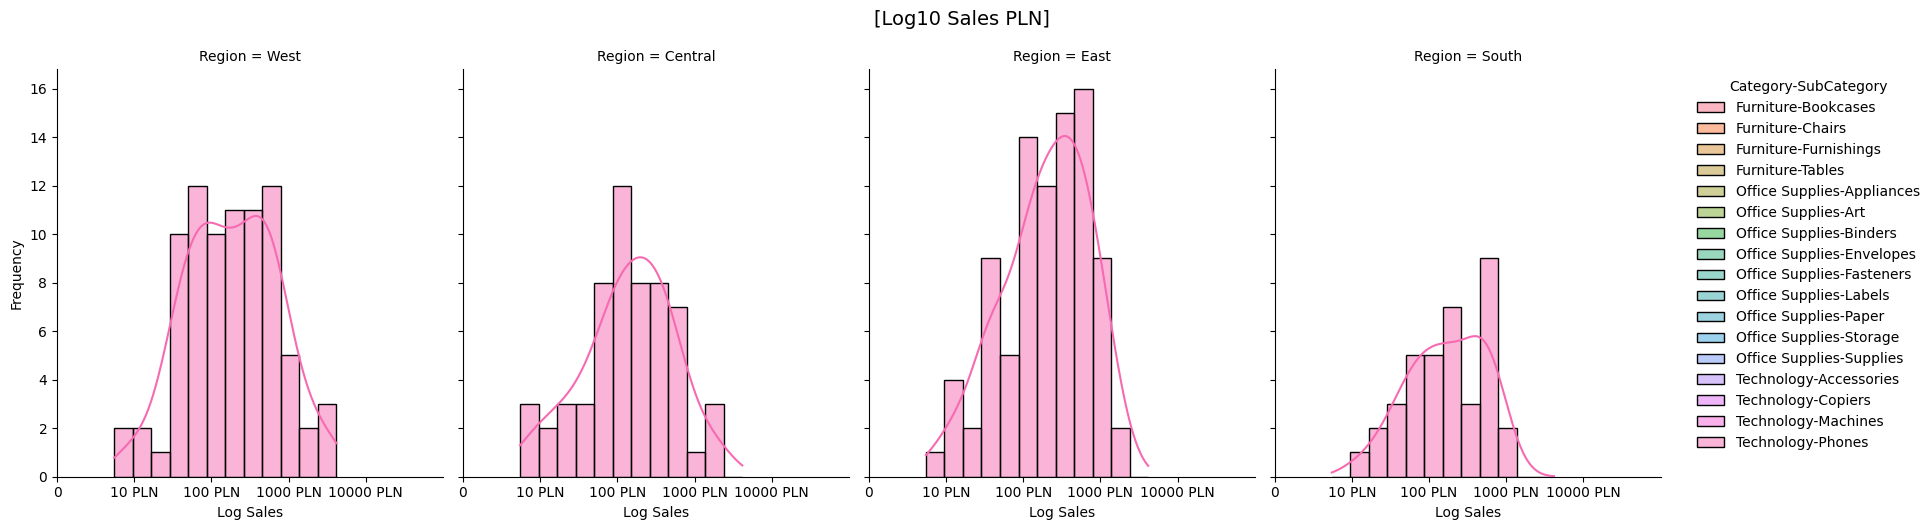

4 Furniture-Bookcases


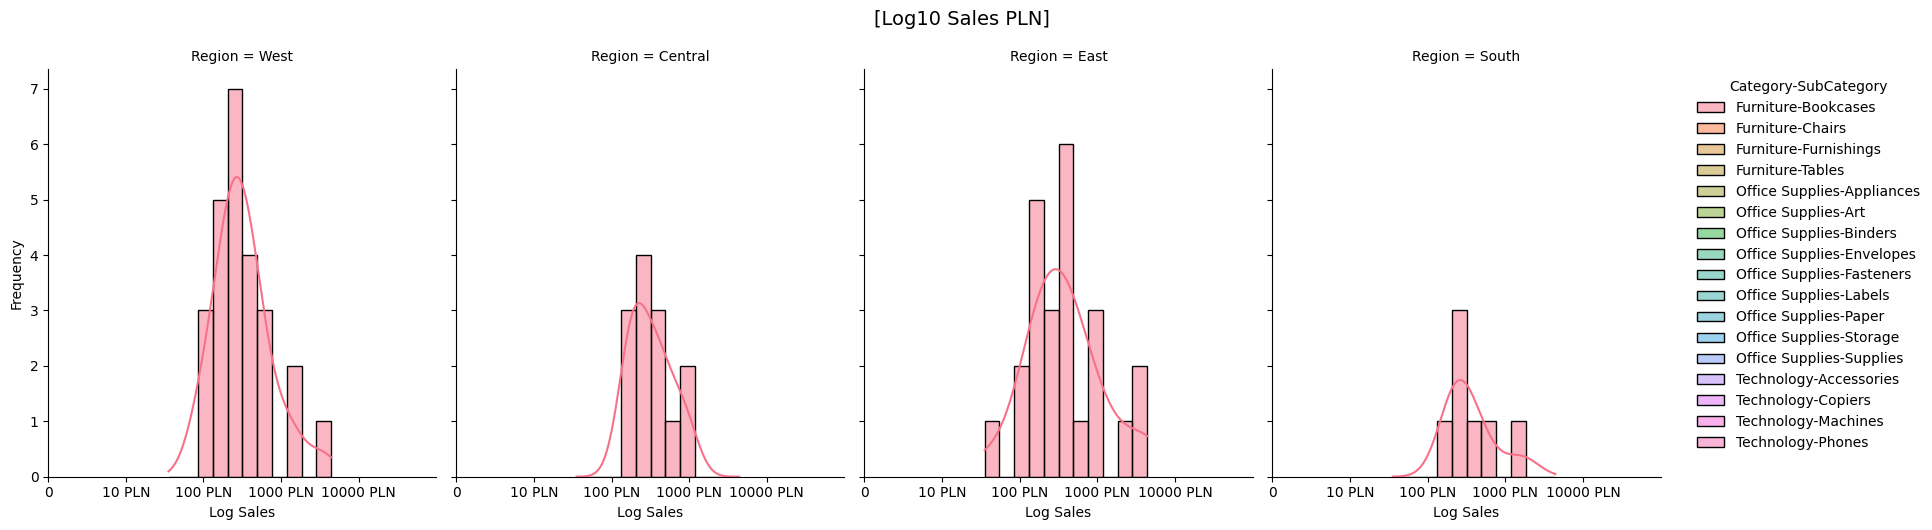

5 Office Supplies-Paper


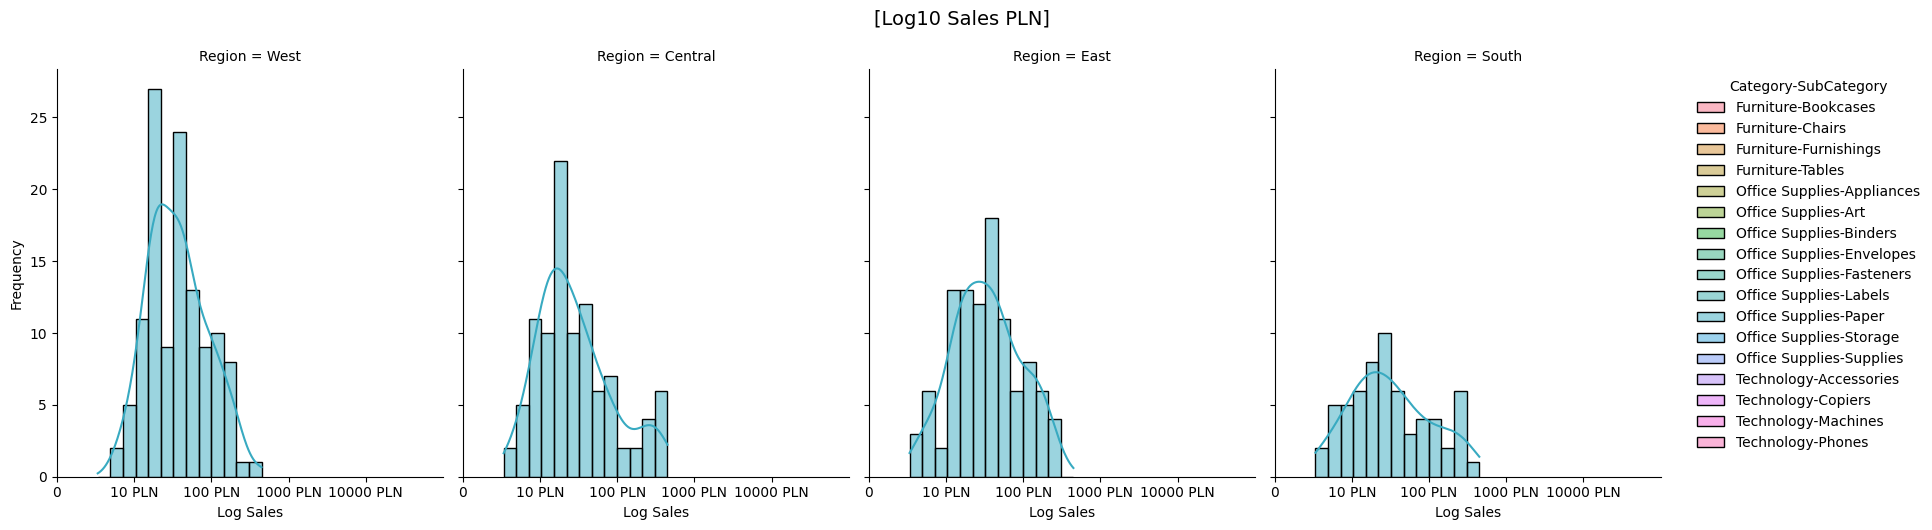

6 Furniture-Chairs


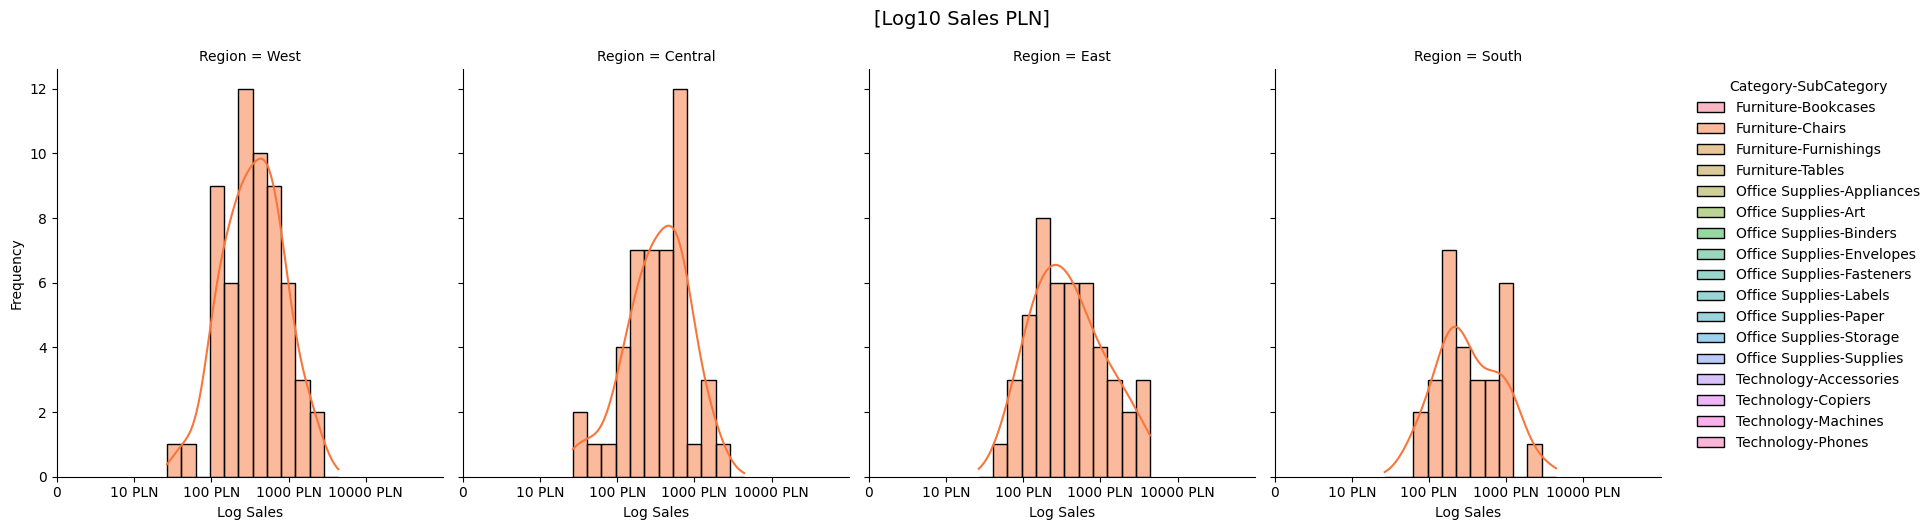

7 Office Supplies-Art


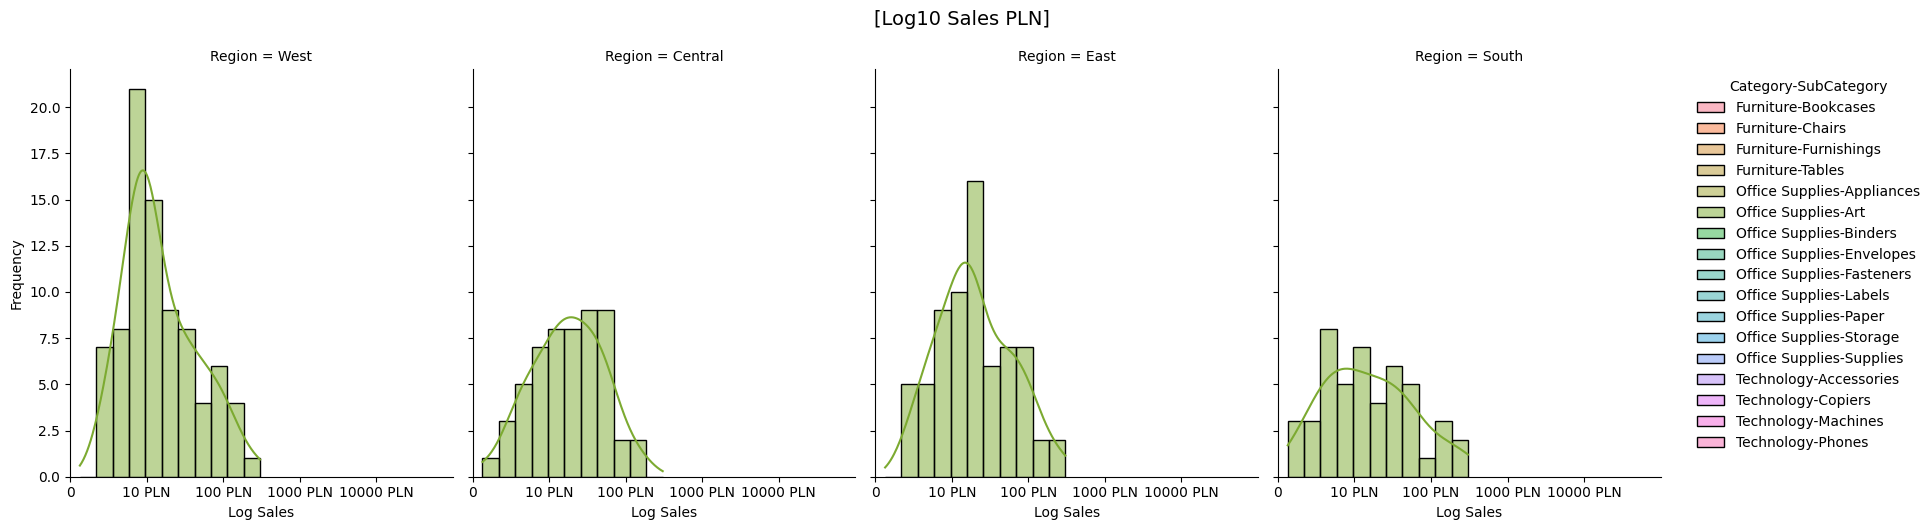

8 Office Supplies-Binders


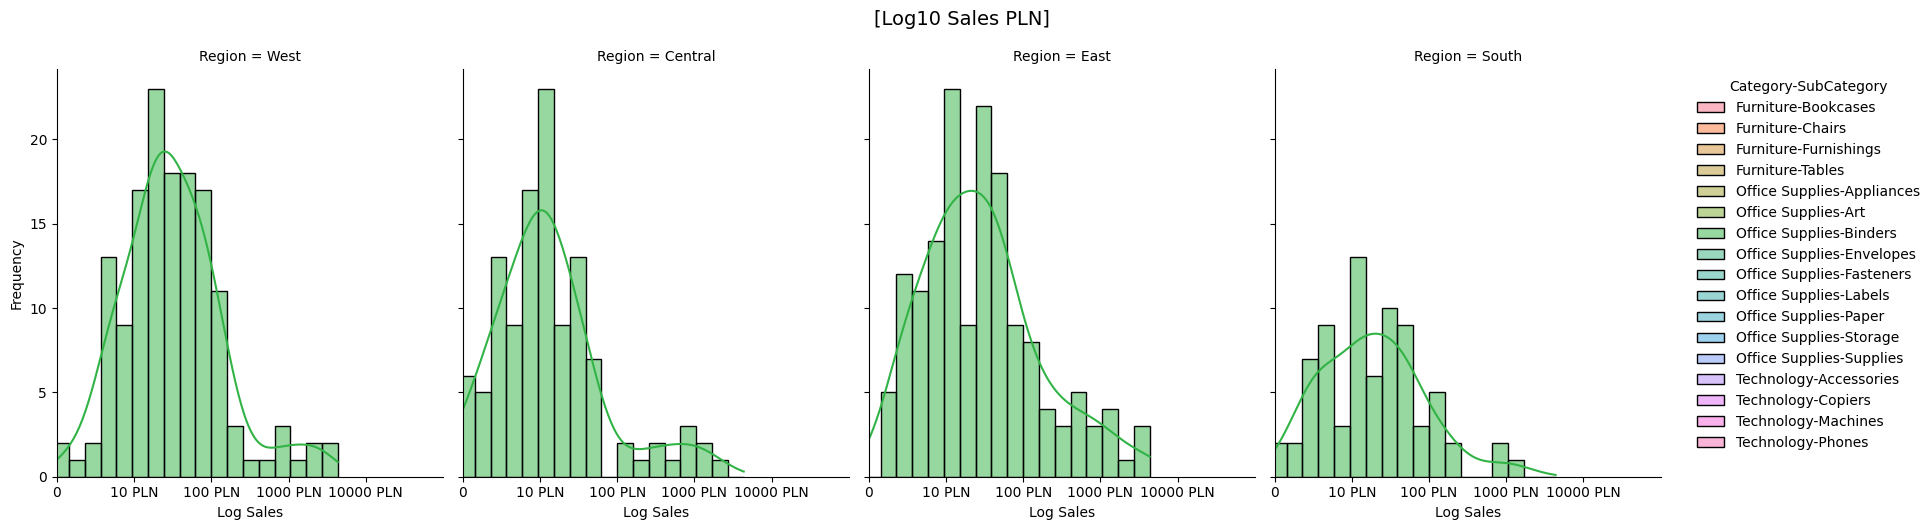

9 Office Supplies-Envelopes


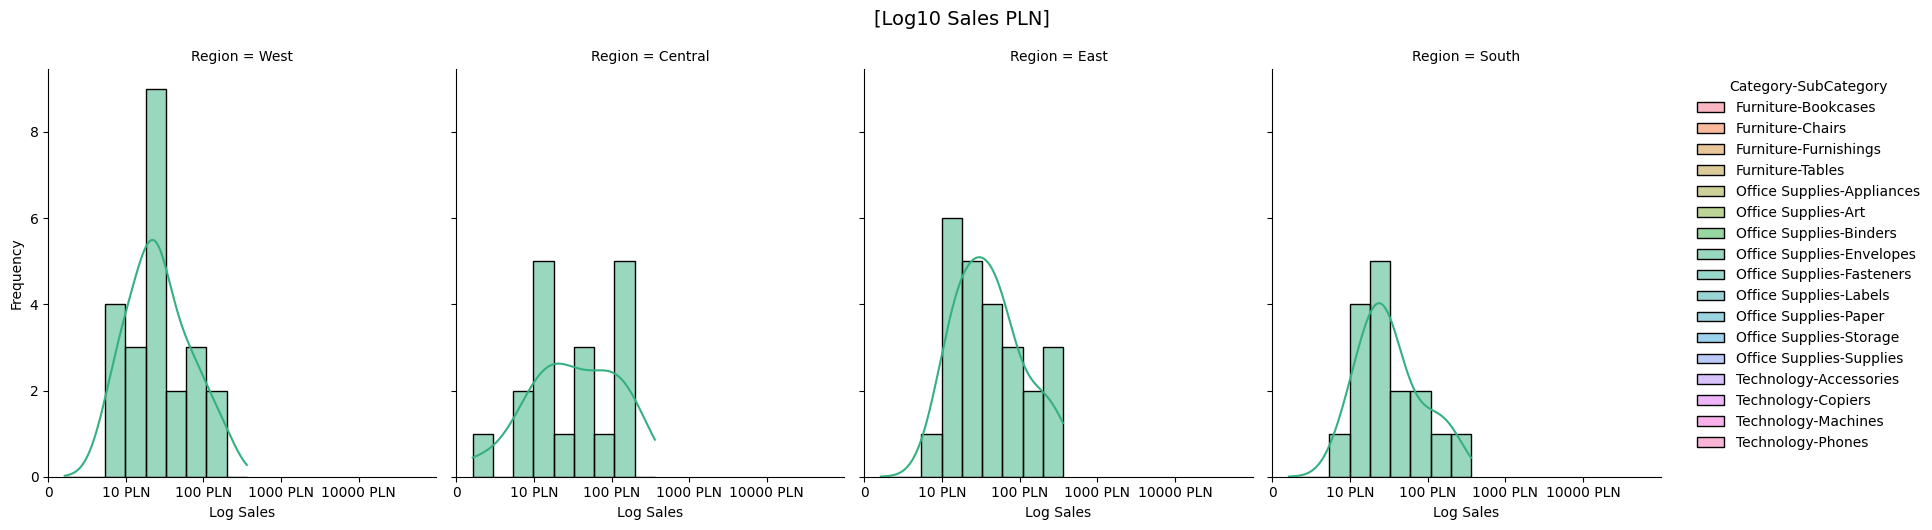

10 Office Supplies-Supplies


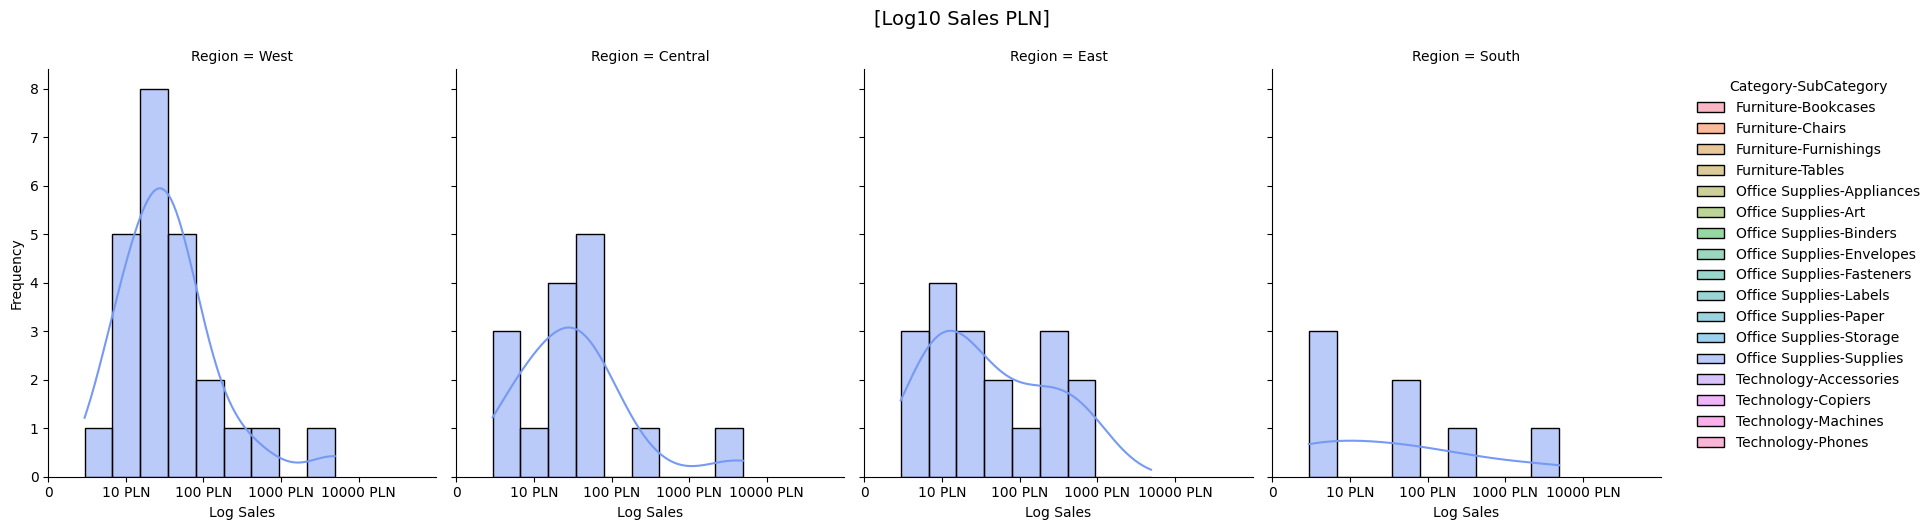

11 Office Supplies-Labels


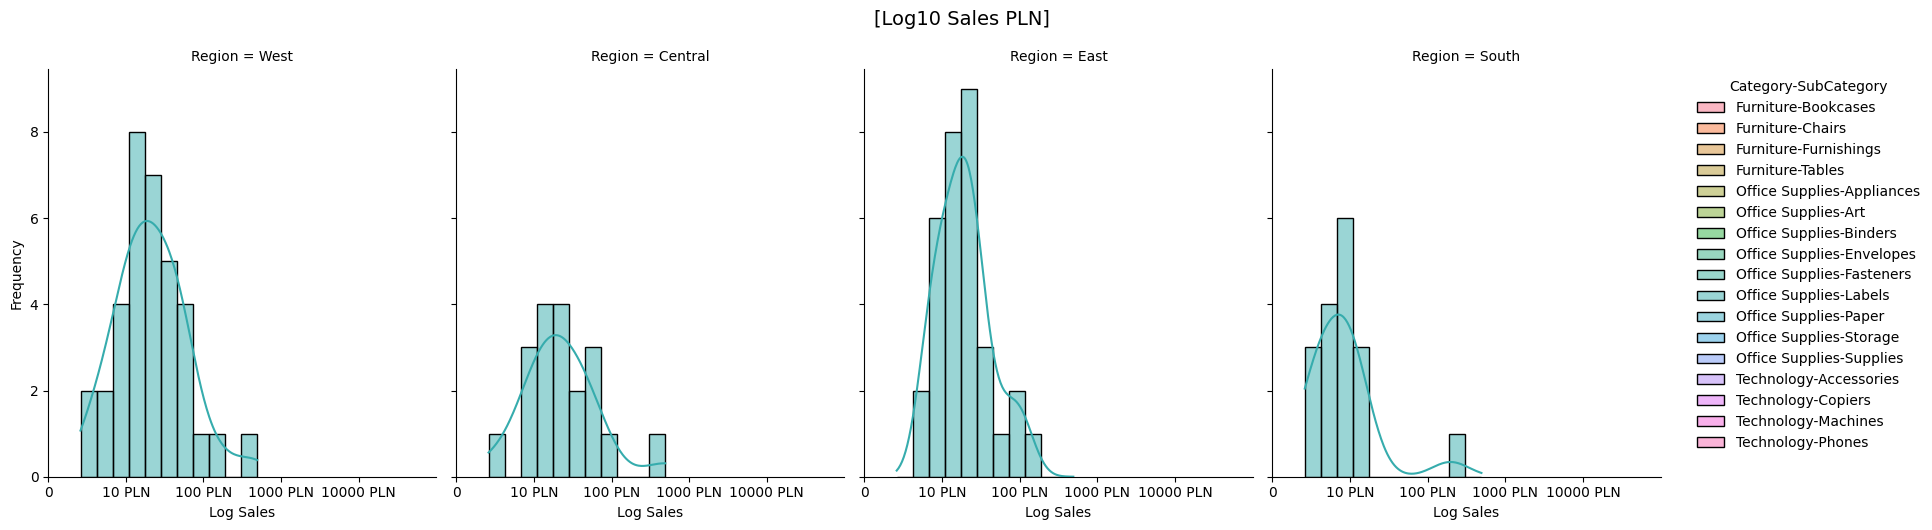

12 Office Supplies-Appliances


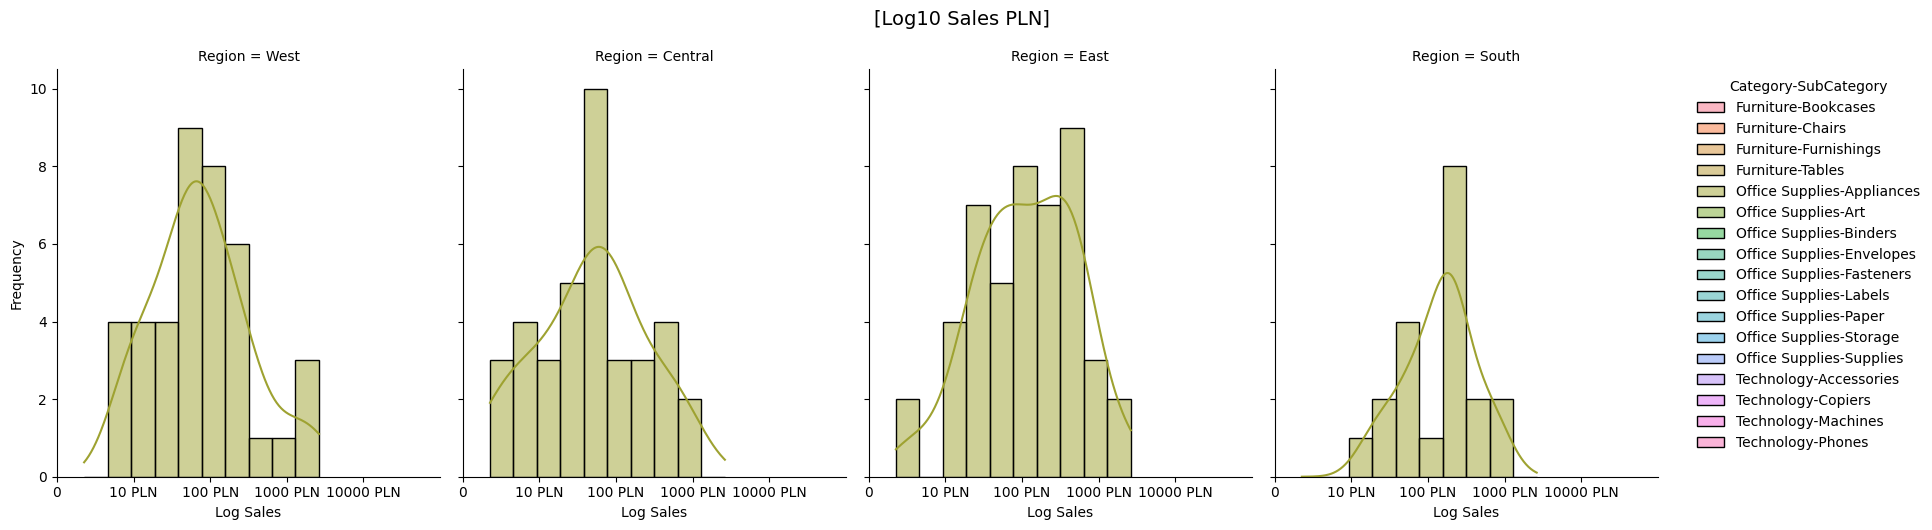

13 Furniture-Tables


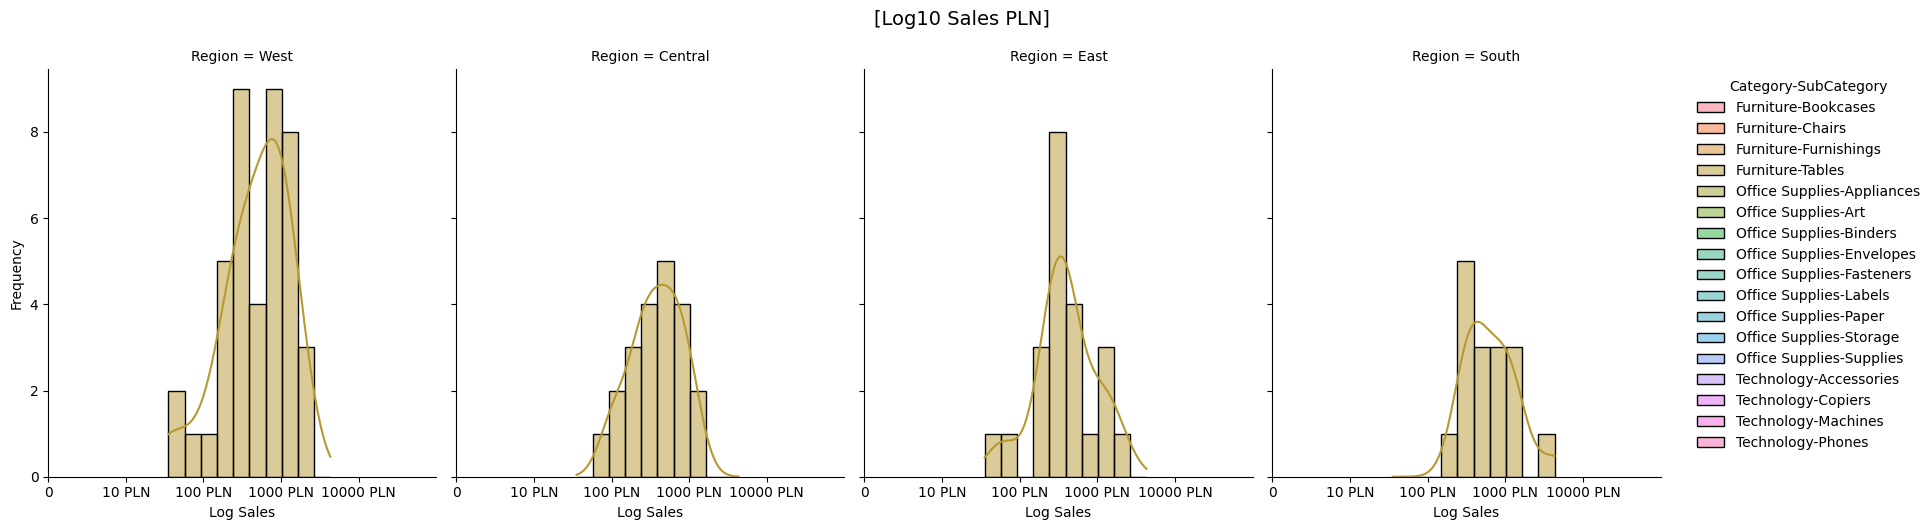

14 Technology-Machines


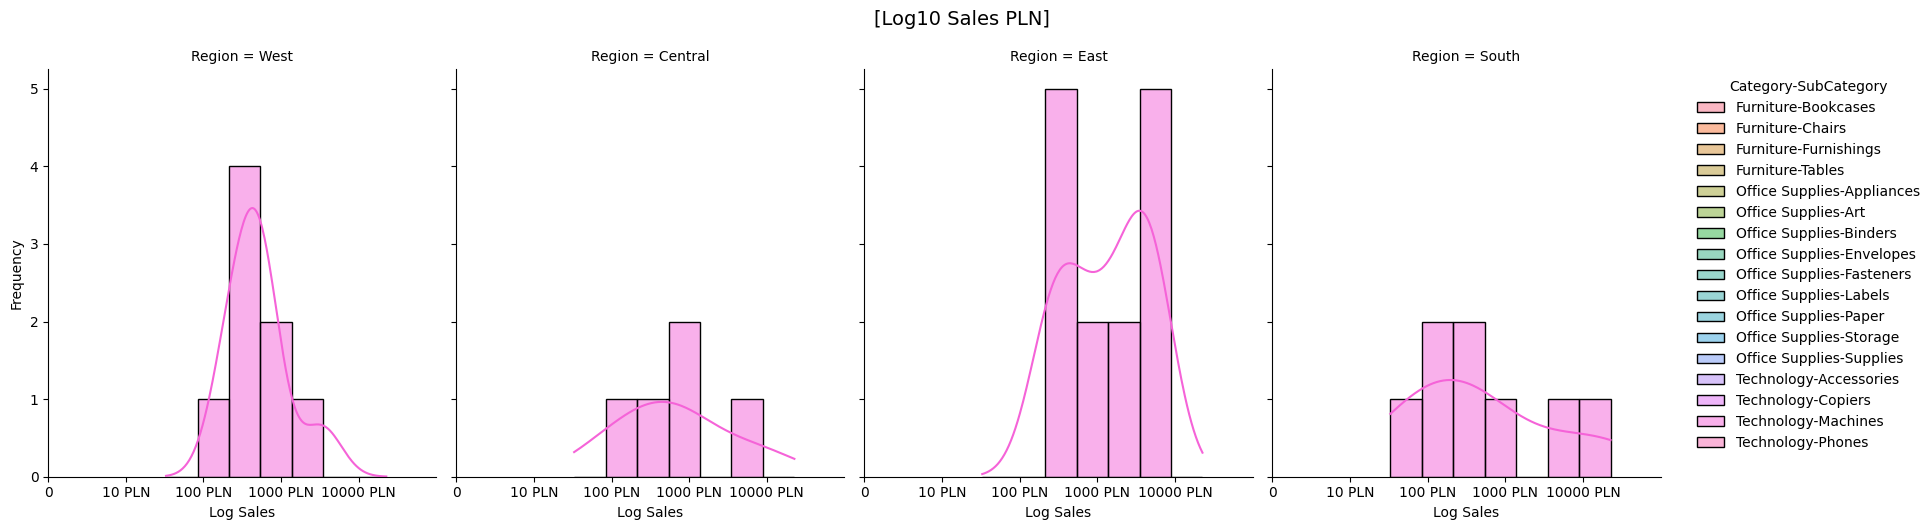

15 Office Supplies-Fasteners


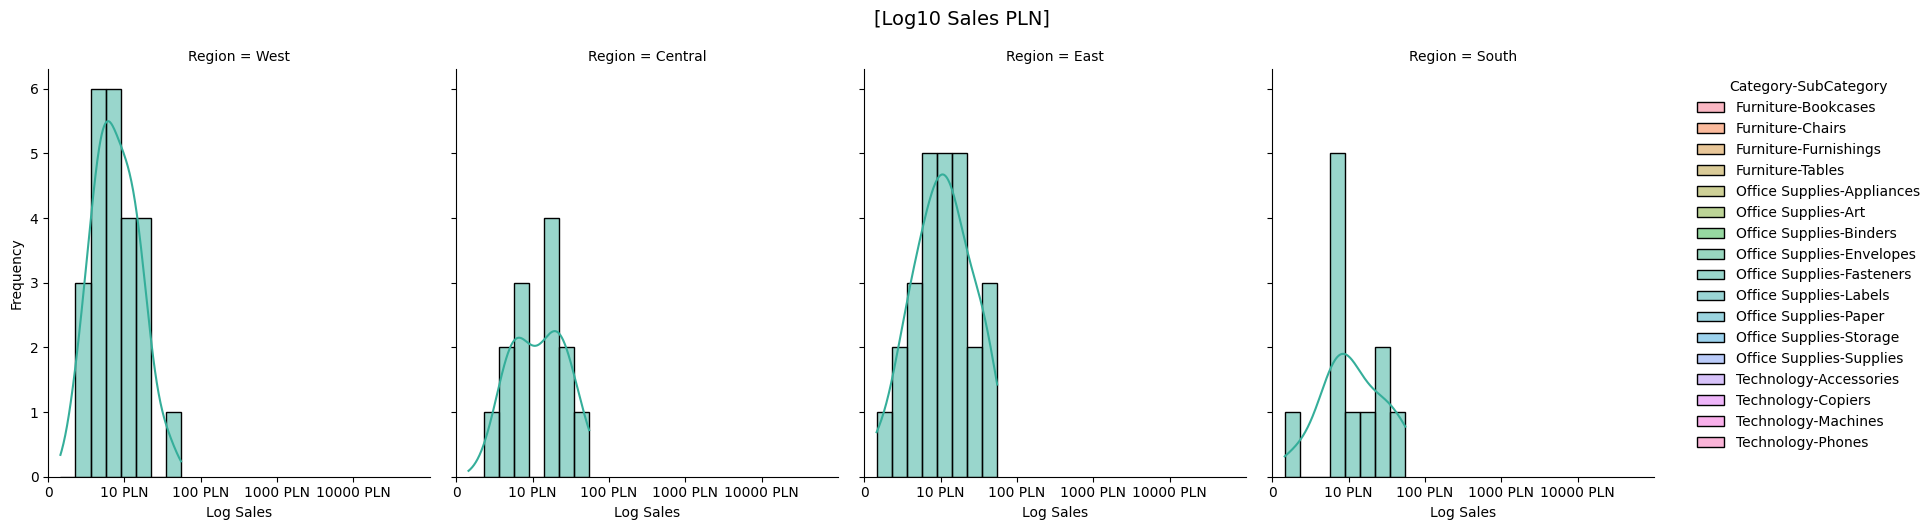

16 Technology-Copiers


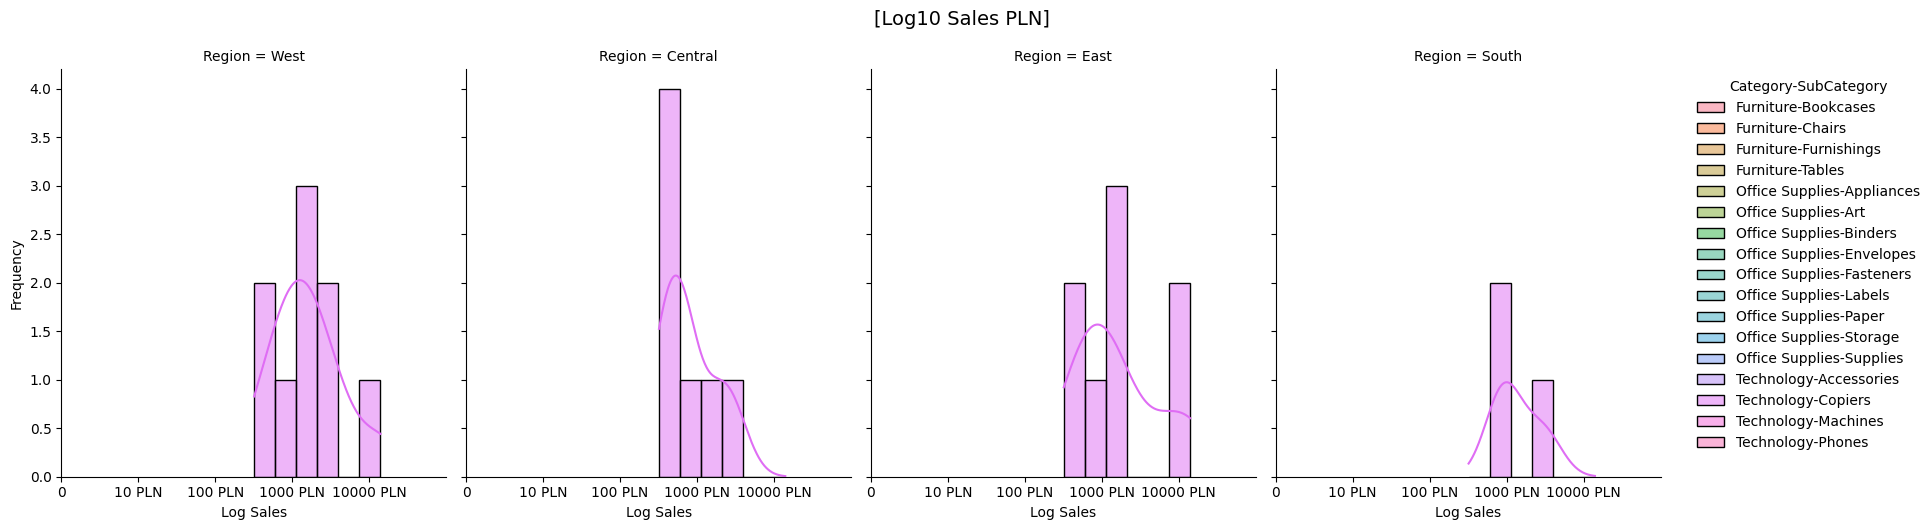

In [30]:
for c, cat in sorted(enumerate(df_sample["Category-SubCategory"].unique())):
    print(c, cat)
    # Create a histogram with groupings based on Order Year
    g = sns.displot(data=df_sample[df_sample["Category-SubCategory"] == cat],
                    x="Log Sales", hue="Category-SubCategory", kde=True, hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85)

    # Customize the plot
    g.set(xlim=(0, 5), xlabel="Log Sales", ylabel="Frequency")
    g.fig.suptitle(f"[Log10 Sales PLN]", fontsize=14, y=1.05)

    # Set the x-axis ticks to [0, 10, 100, 1000]
    g.set(xticks=[0, 1, 2, 3, 4], xticklabels=["0", "10 PLN", "100 PLN", "1000 PLN", "10000 PLN"])
    # g.axes[0][0].xaxis.set_major_formatter(ticker.ScalarFormatter())

    # Show the plot
    plt.show()

# BOX PLOTS

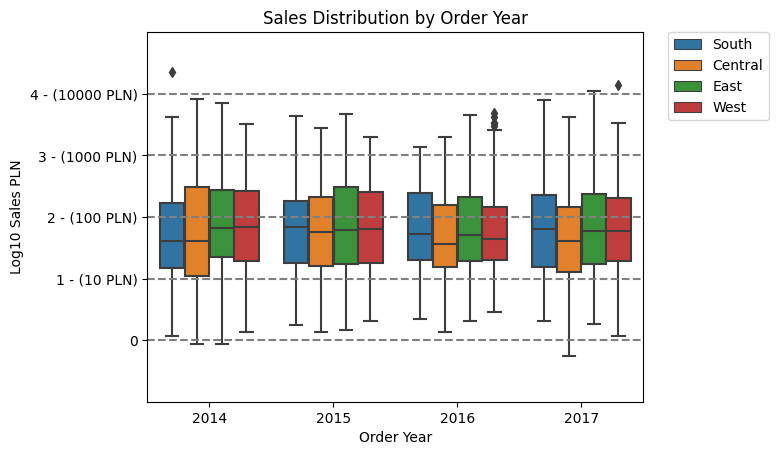

In [31]:
# Define the order of years
year_order = sorted(df_sample["Order Year"].unique())

# Create a box plot with groupings based on Order Year
g = sns.boxplot(data=df_sample, x="Order Year", y="Log Sales", hue="Region", order=year_order)

# Customize the plot
g.set(ylim=(-1, 5), xlabel="Order Year", ylabel="Log10 Sales PLN", title="Sales Distribution by Order Year")

g.set(yticks=[0, 1, 2, 3, 4], yticklabels=["0", "1 - (10 PLN)", "2 - (100 PLN)", "3 - (1000 PLN)", "4 - (10000 PLN)"])
# Move the legend outside the chart box
# Add horizontal lines at each ytick
yticks = plt.yticks()[0]
for ytick in yticks:
    plt.axhline(ytick, color='gray', linestyle='--')

# Move the legend outside the chart box
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

2014
2015
2016
2017


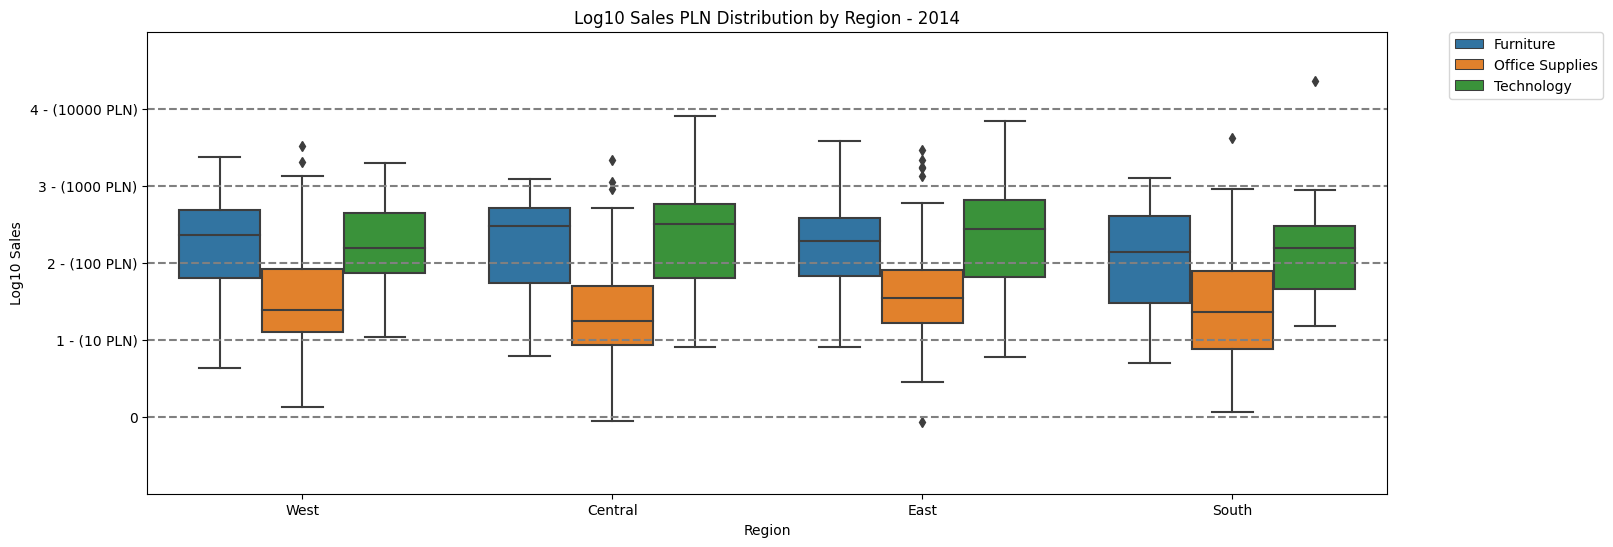

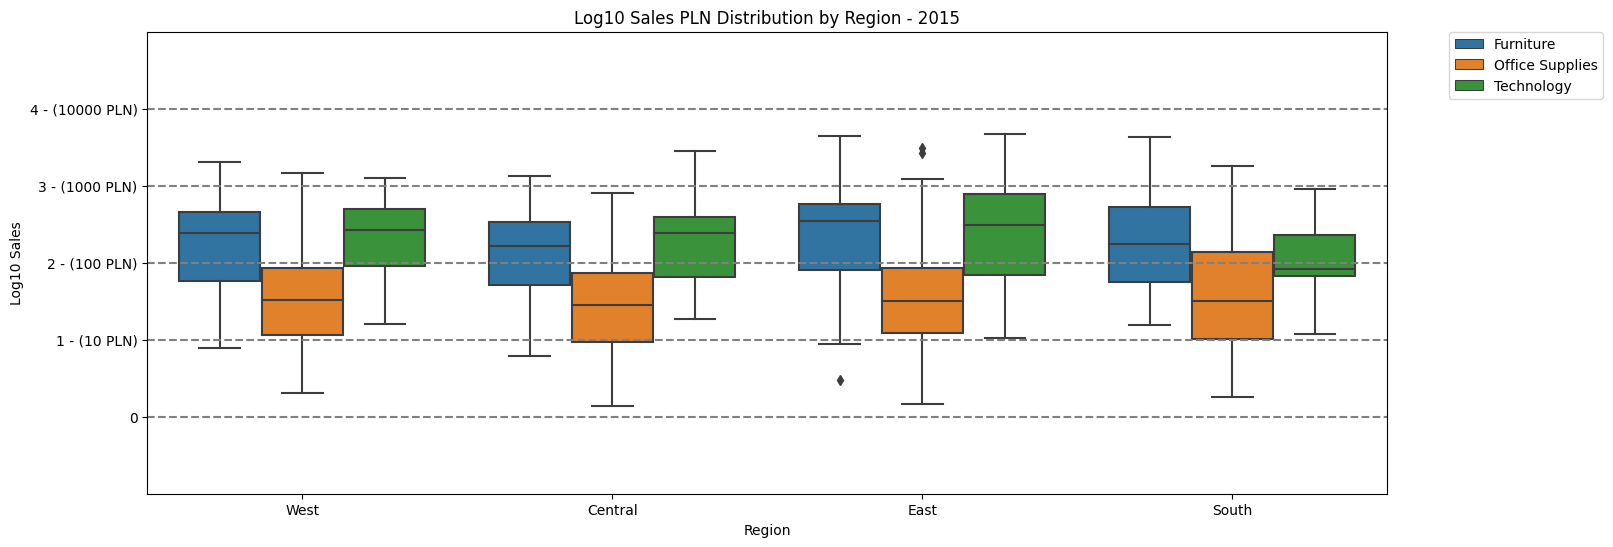

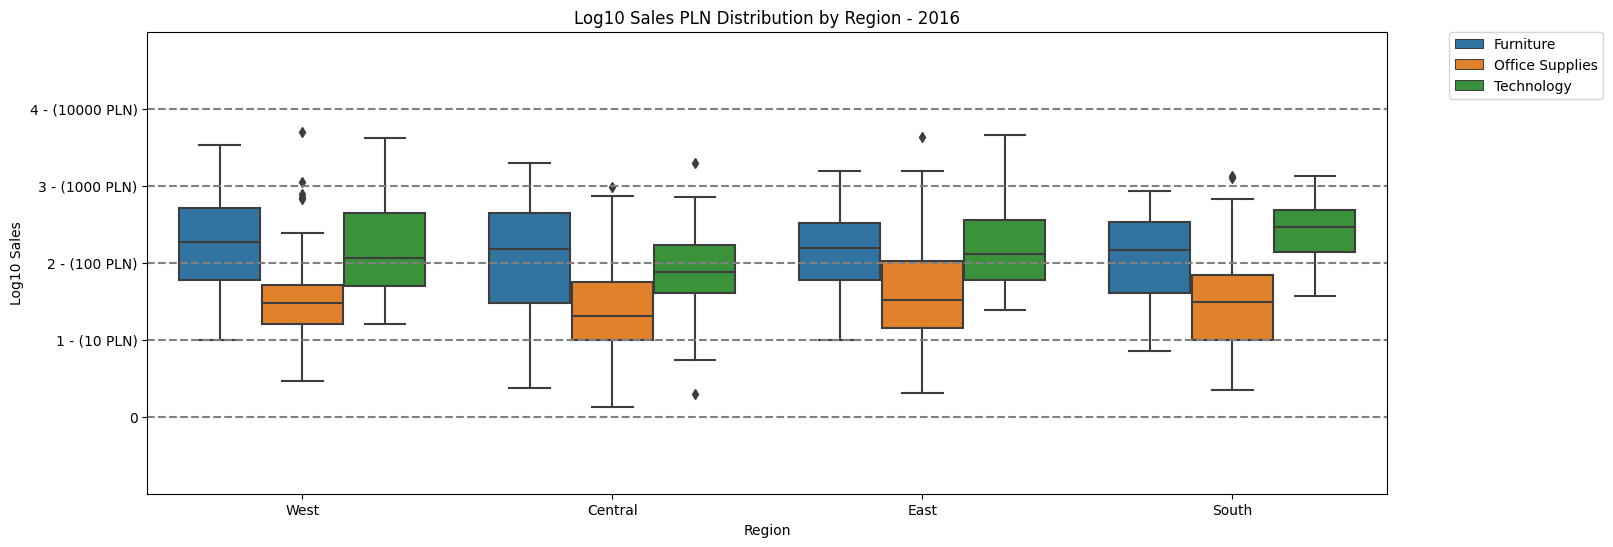

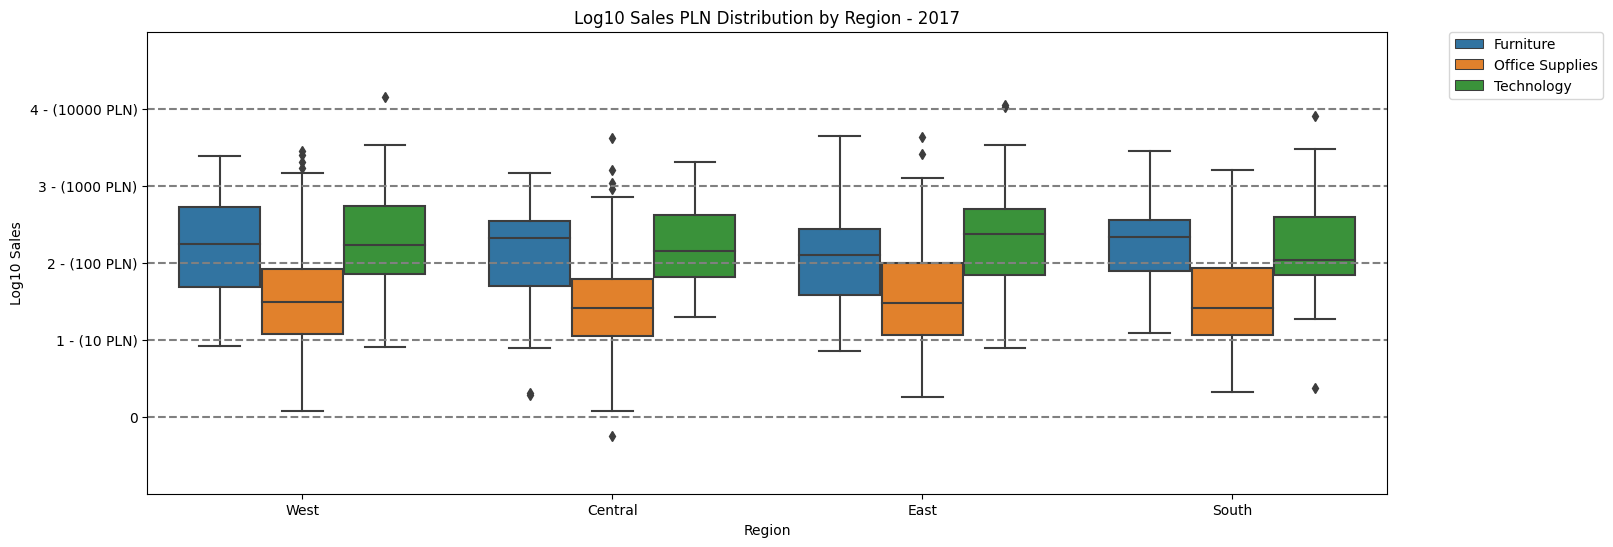

In [32]:
# # Define the order of years
# year_order = sorted(df_sample["Order Year"].unique())
for i, v in enumerate(sorted(df["Order Year"].unique())):
    print(v)
    
    # Set the figure size
    plt.figure(figsize=(16, 6))

    # Create a box plot with groupings based on Order Year
    g = sns.boxplot(data=df_sample[df_sample["Order Year"] == v], x="Region", y="Log Sales", hue="Category", order=COL_ORDER, hue_order=X_ORDER)

    # Customize the plot
    g.set(ylim=(-1, 5), xlabel="Region", ylabel="Log10 Sales", title=f"Log10 Sales PLN Distribution by Region - {v}")
    g.set(yticks=[0, 1, 2, 3, 4], yticklabels=["0", "1 - (10 PLN)", "2 - (100 PLN)", "3 - (1000 PLN)", "4 - (10000 PLN)"])
    # Add horizontal lines at each ytick
    yticks = plt.yticks()[0]
    for ytick in yticks:
        plt.axhline(ytick, color='gray', linestyle='--')
    # Move the legend outside the chart box
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

2014
2015
2016
2017


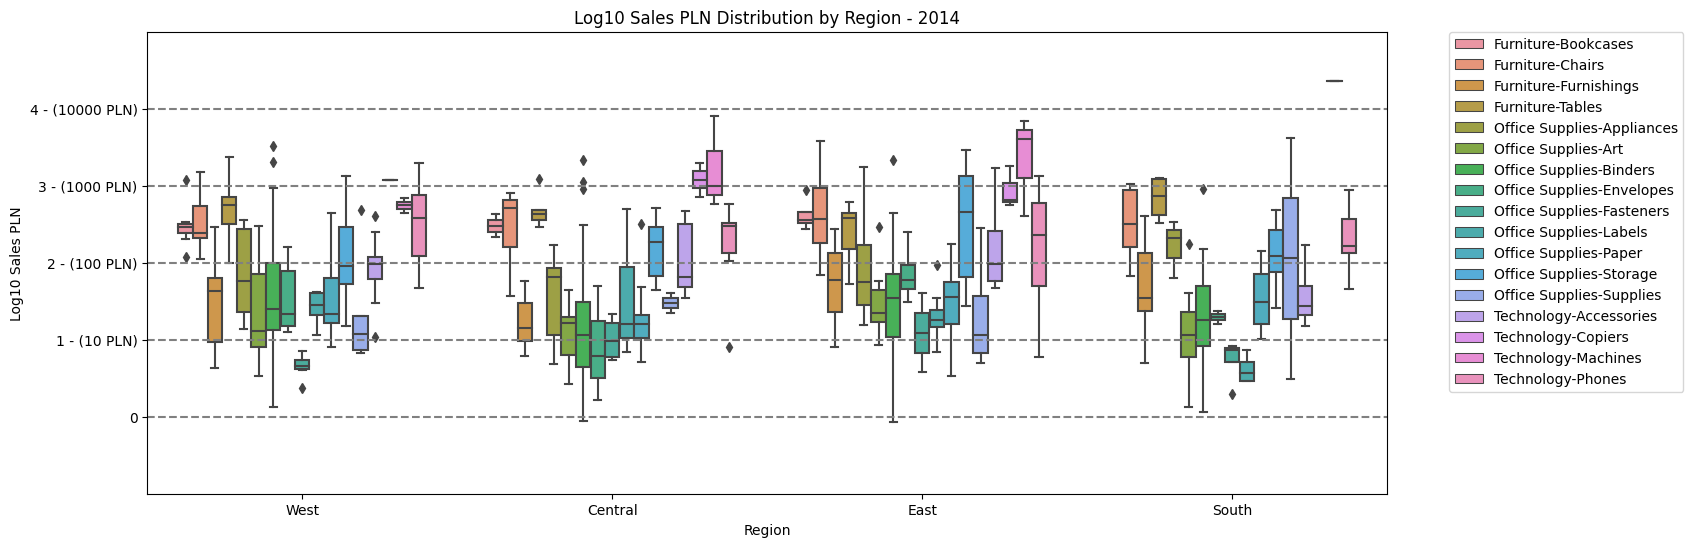

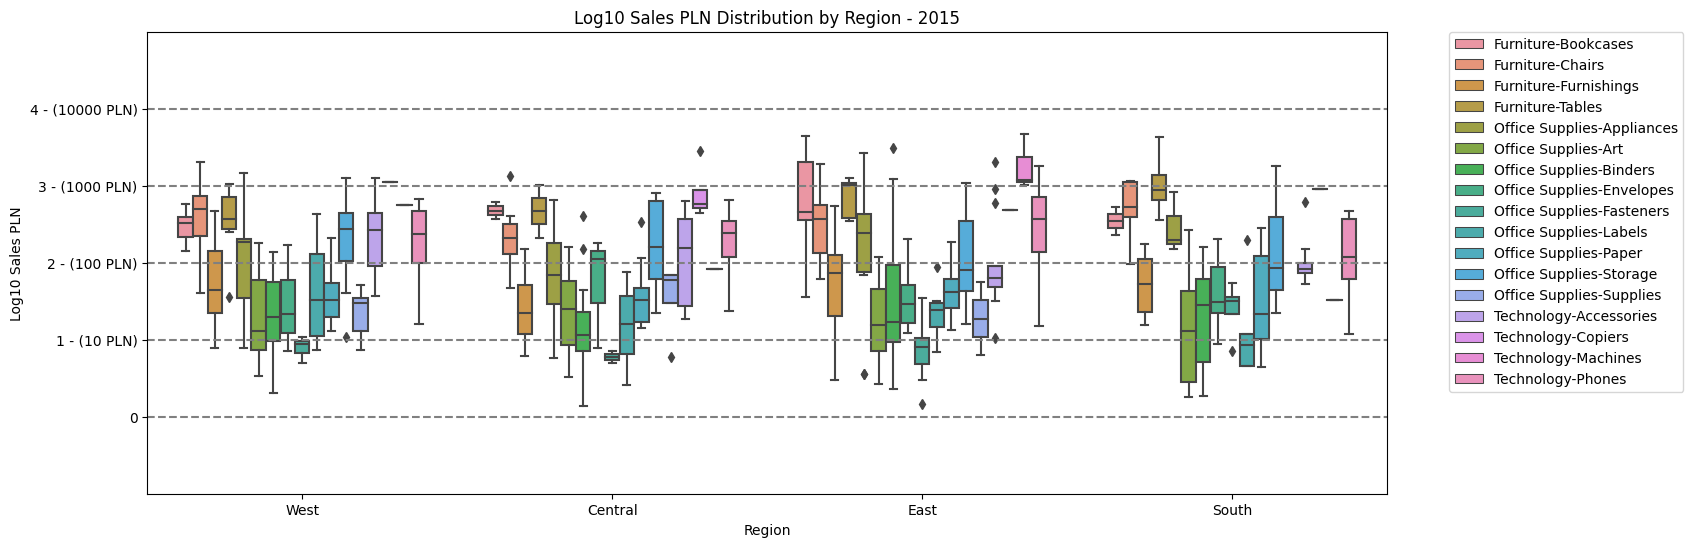

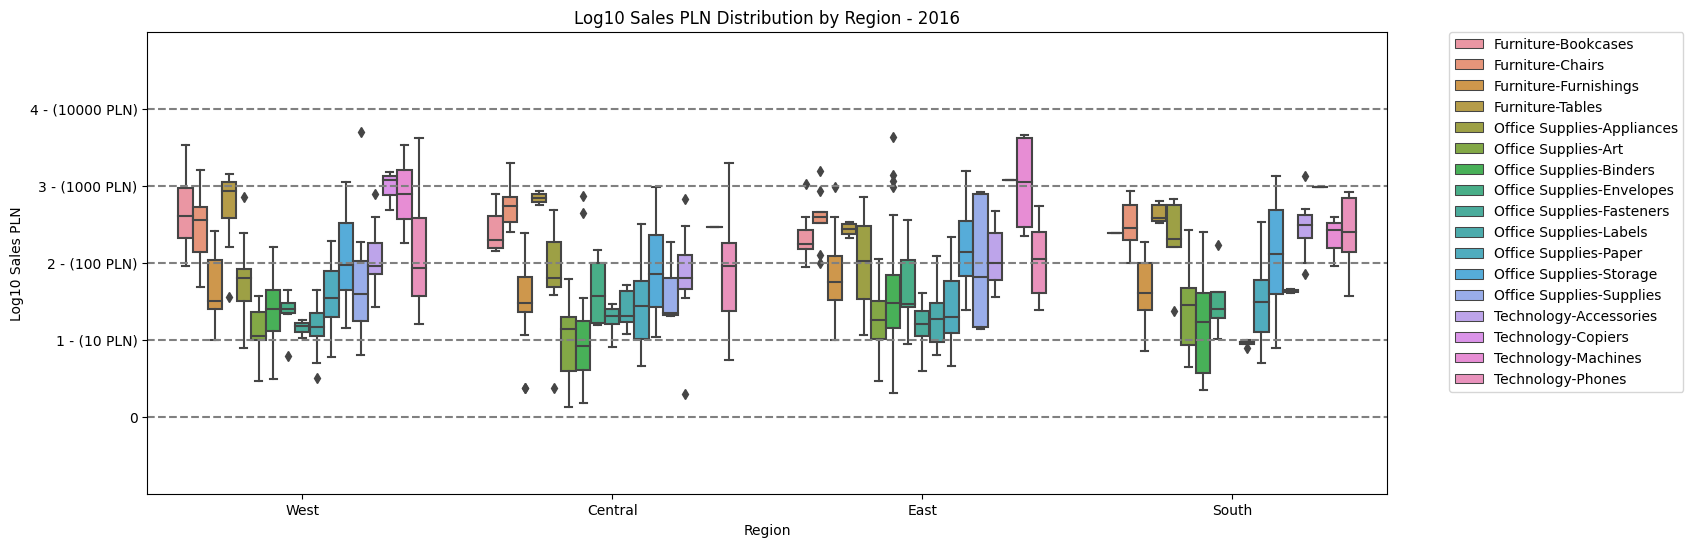

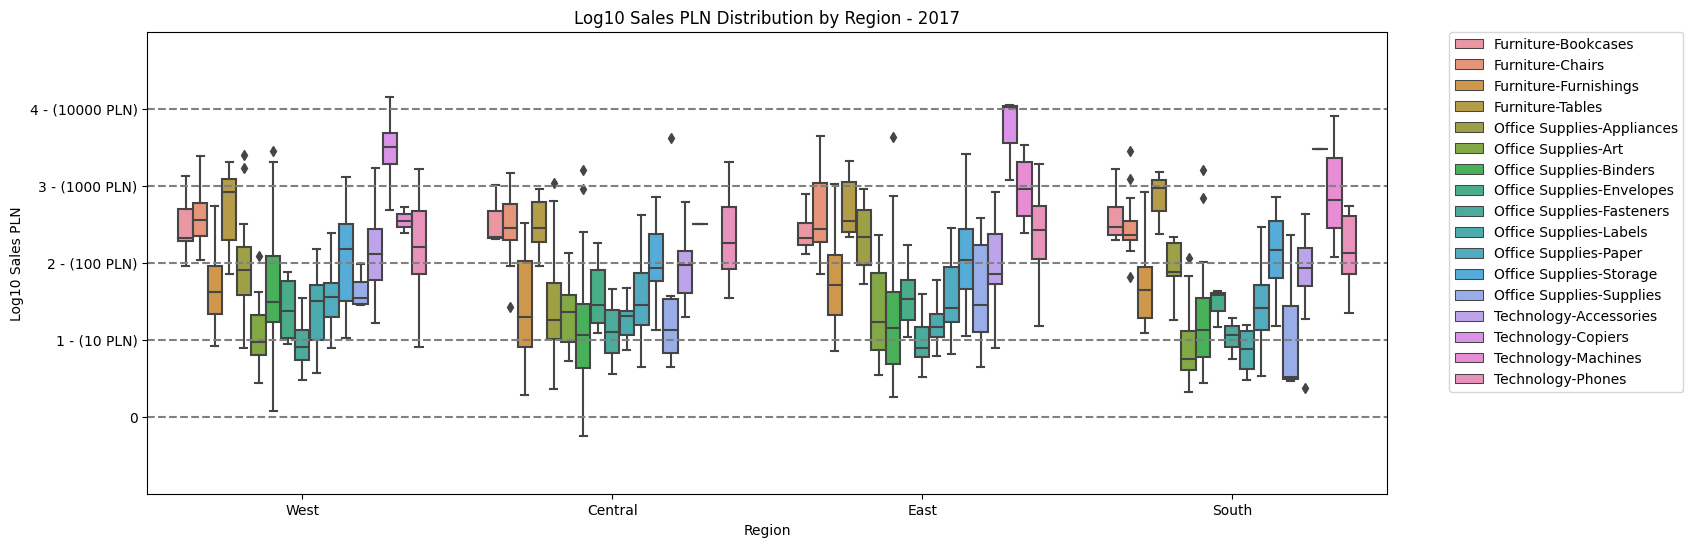

In [33]:
# # Define the order of years
# year_order = sorted(df_sample["Order Year"].unique())
for i, v in enumerate(sorted(df["Order Year"].unique())):
    print(v)
    
    # # Define the order of years
    # year_order = sorted(df_sample["Order Year"].unique())

    # Set the figure size
    plt.figure(figsize=(16, 6))

    # Create a box plot with groupings based on Order Year
    g = sns.boxplot(data=df_sample[df_sample["Order Year"] == v], x="Region", y="Log Sales", hue="Category-SubCategory", order=COL_ORDER, hue_order=HUE_ORDER)

    # Customize the plot
    g.set(ylim=(-1, 5), xlabel="Region", ylabel="Log10 Sales PLN", title=f"Log10 Sales PLN Distribution by Region - {v}")
    g.set(yticks=[0, 1, 2, 3, 4], yticklabels=["0", "1 - (10 PLN)", "2 - (100 PLN)", "3 - (1000 PLN)", "4 - (10000 PLN)"])
    # Move the legend outside the chart box
    # Add horizontal lines at each ytick
    yticks = plt.yticks()[0]
    for ytick in yticks:
        plt.axhline(ytick, color='gray', linestyle='--')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# SWARM PLOTS

## Winsorized Sales

Text(0.5, 1.05, '[Winsorized Sales]')

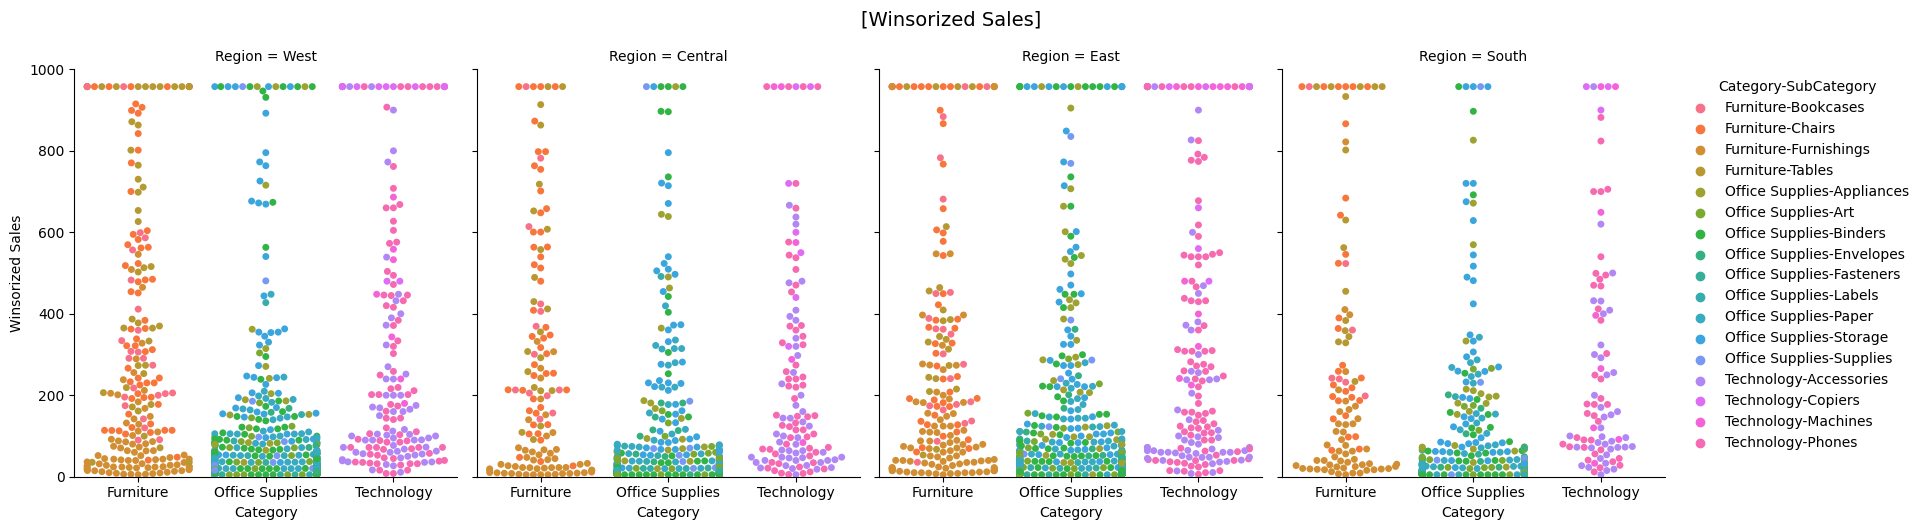

In [34]:
g = sns.catplot(
    data=df_sample, kind="swarm",
    x="Category", order=X_ORDER, y="Winsorized Sales", hue="Category-SubCategory", hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85
)
g.set(ylim=(0, 1000))
g.fig.suptitle(f"[Winsorized Sales]", fontsize=14, y=1.05)

2014
2015
2016
2017


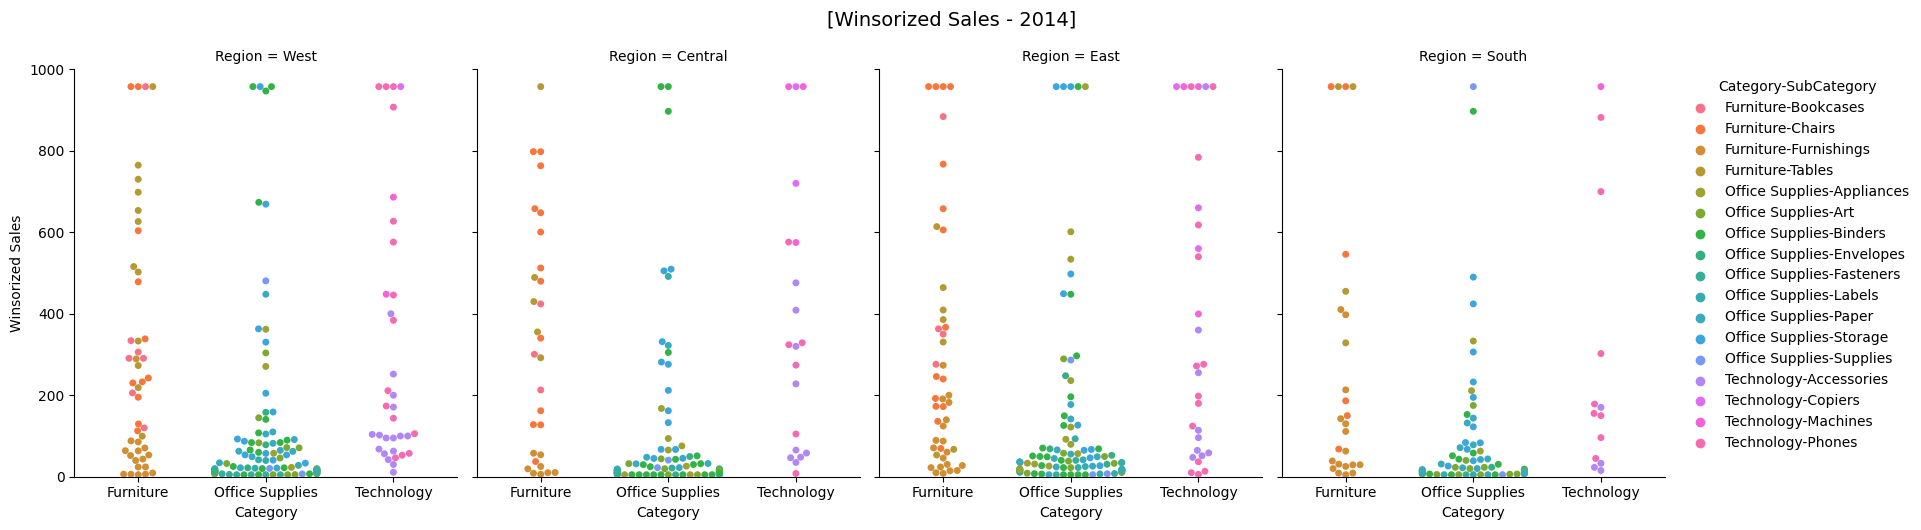

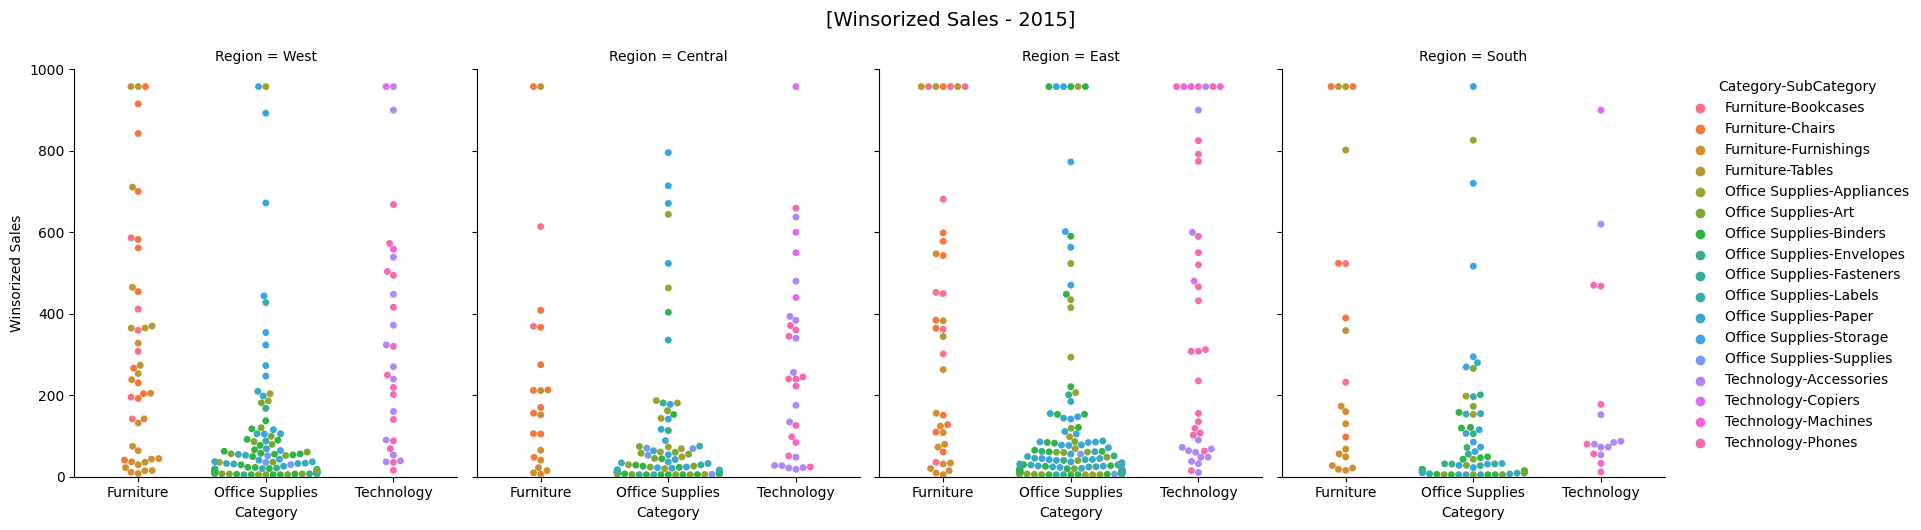

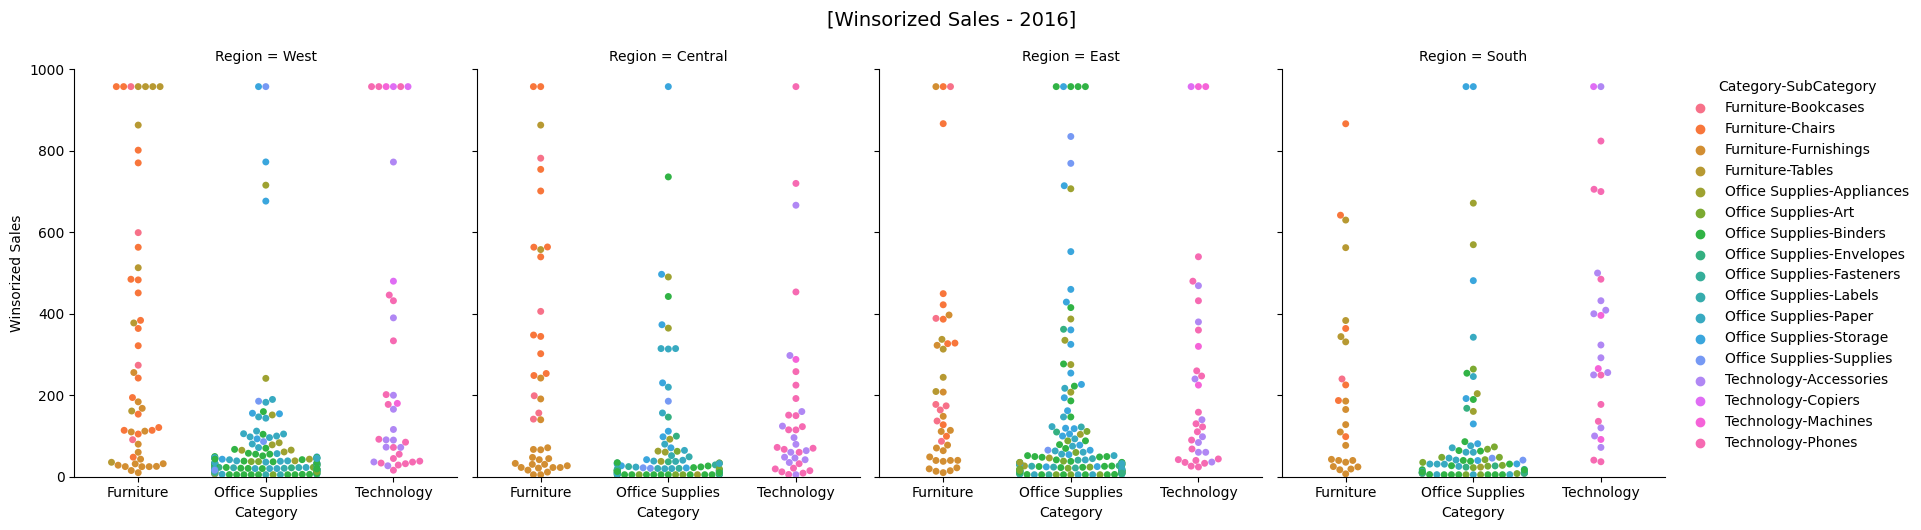

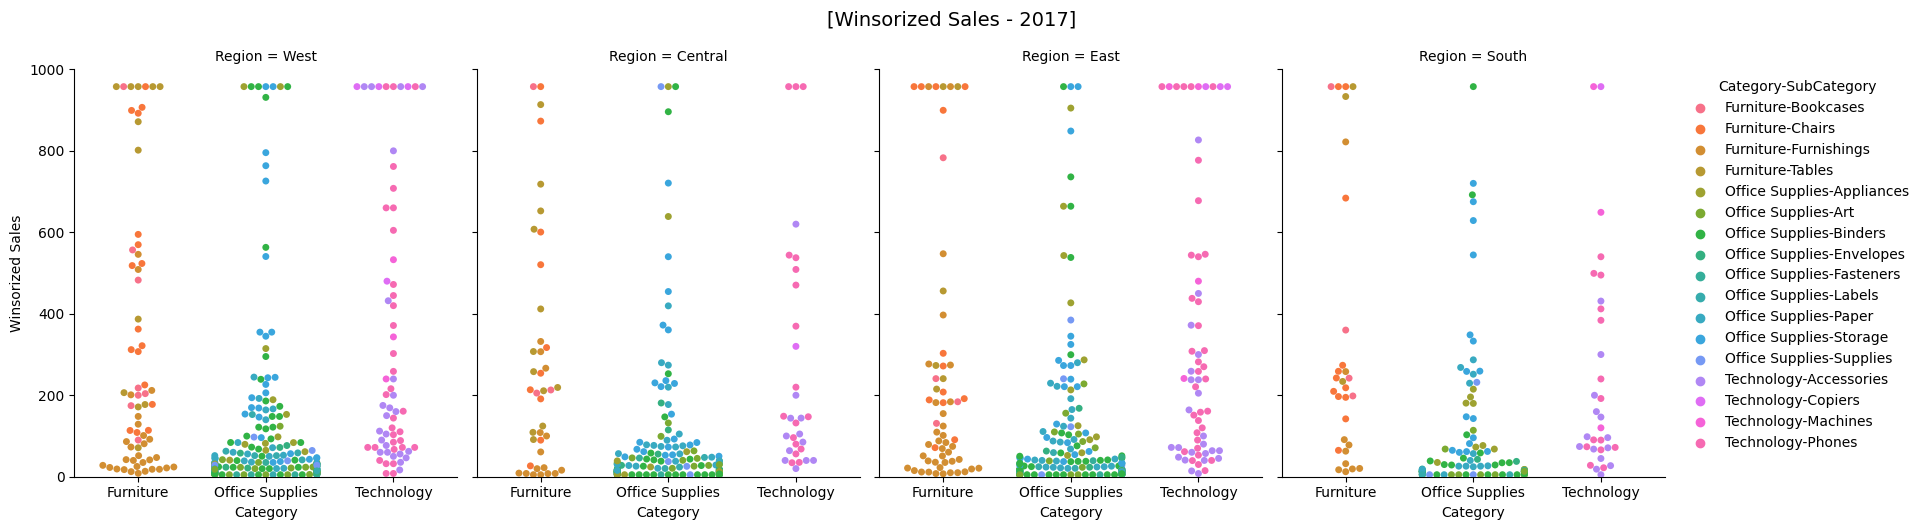

In [35]:
for i, v in enumerate(sorted(df["Order Year"].unique())):
    print(v)
    g = sns.catplot(
        data=df_sample[df_sample["Order Year"] == v], kind="swarm",
        x="Category", order=X_ORDER, y="Winsorized Sales", hue="Category-SubCategory", hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85
    )
    g.set(ylim=(0, 1000))
    g.fig.suptitle(f"[Winsorized Sales - {v}]", fontsize=14, y=1.05)

## Log Sales

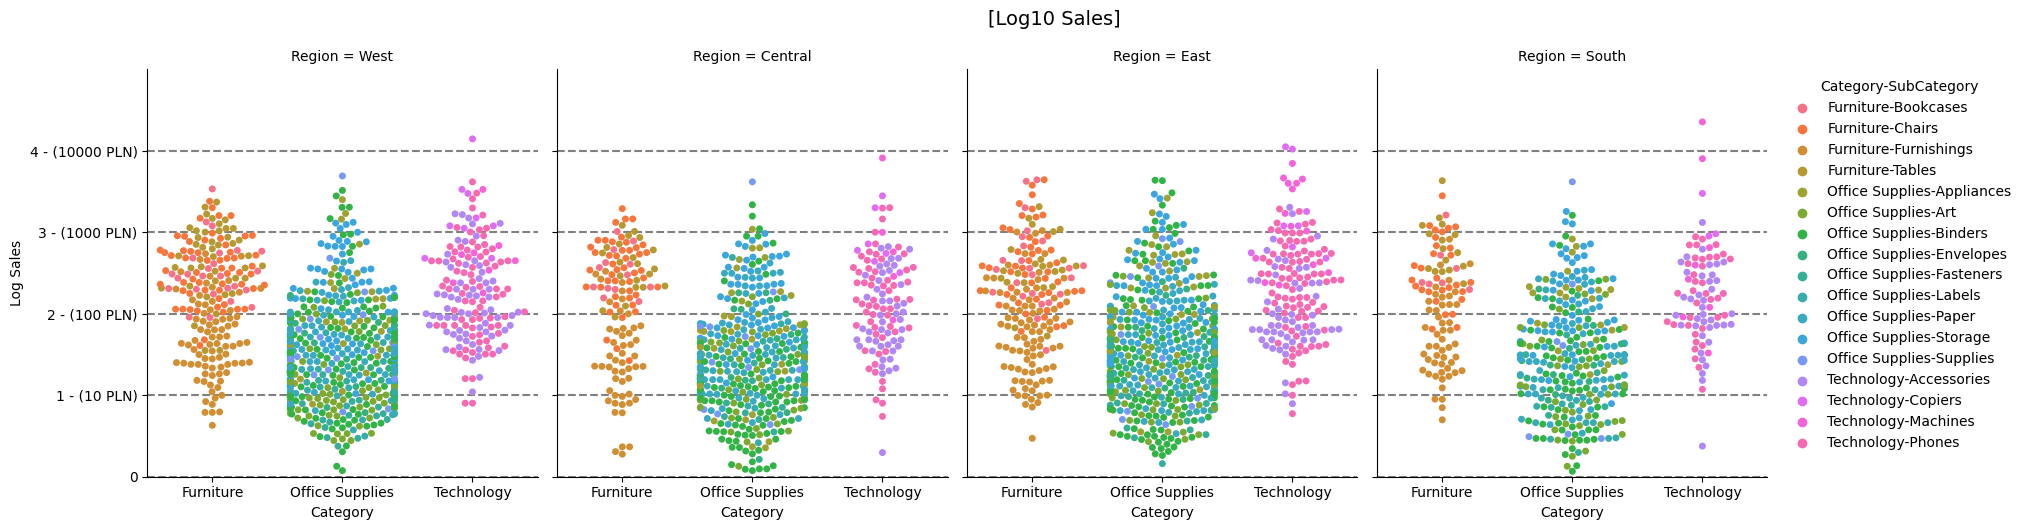

In [36]:
g = sns.catplot(
    data=df_sample, kind="swarm",
    x="Category", order=X_ORDER, y="Log Sales", hue="Category-SubCategory", hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85
)
g.set(ylim=(0, 5))
g.fig.suptitle(f"[Log10 Sales]", fontsize=14, y=1.05)

g.set(yticks=[0, 1, 2, 3, 4], yticklabels=["0", "1 - (10 PLN)", "2 - (100 PLN)", "3 - (1000 PLN)", "4 - (10000 PLN)"])
# Move the legend outside the chart box
# Add horizontal lines at each ytick
for ax in g.axes.flat:
    yticks = ax.get_yticks()
    for ytick in yticks:
        ax.axhline(ytick, color='gray', linestyle='--')


2014
2015
2016
2017


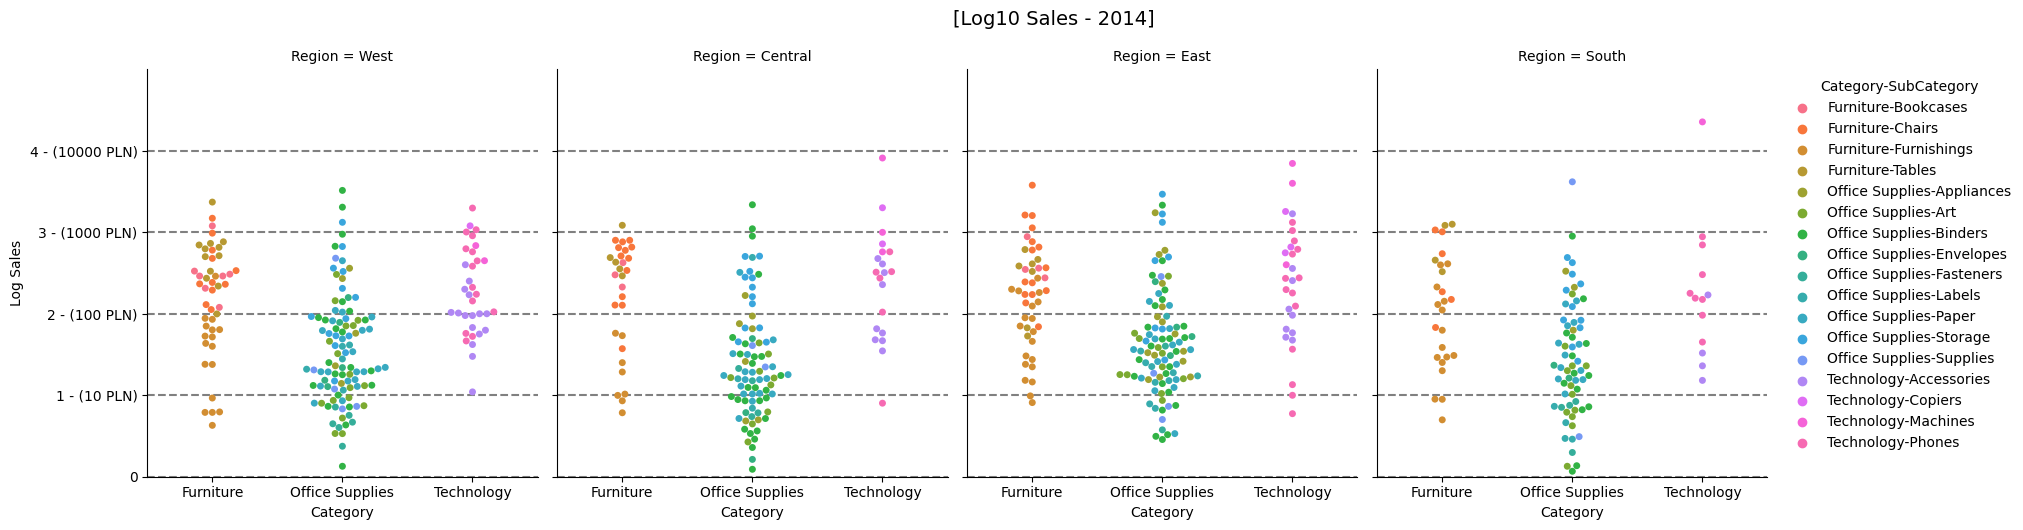

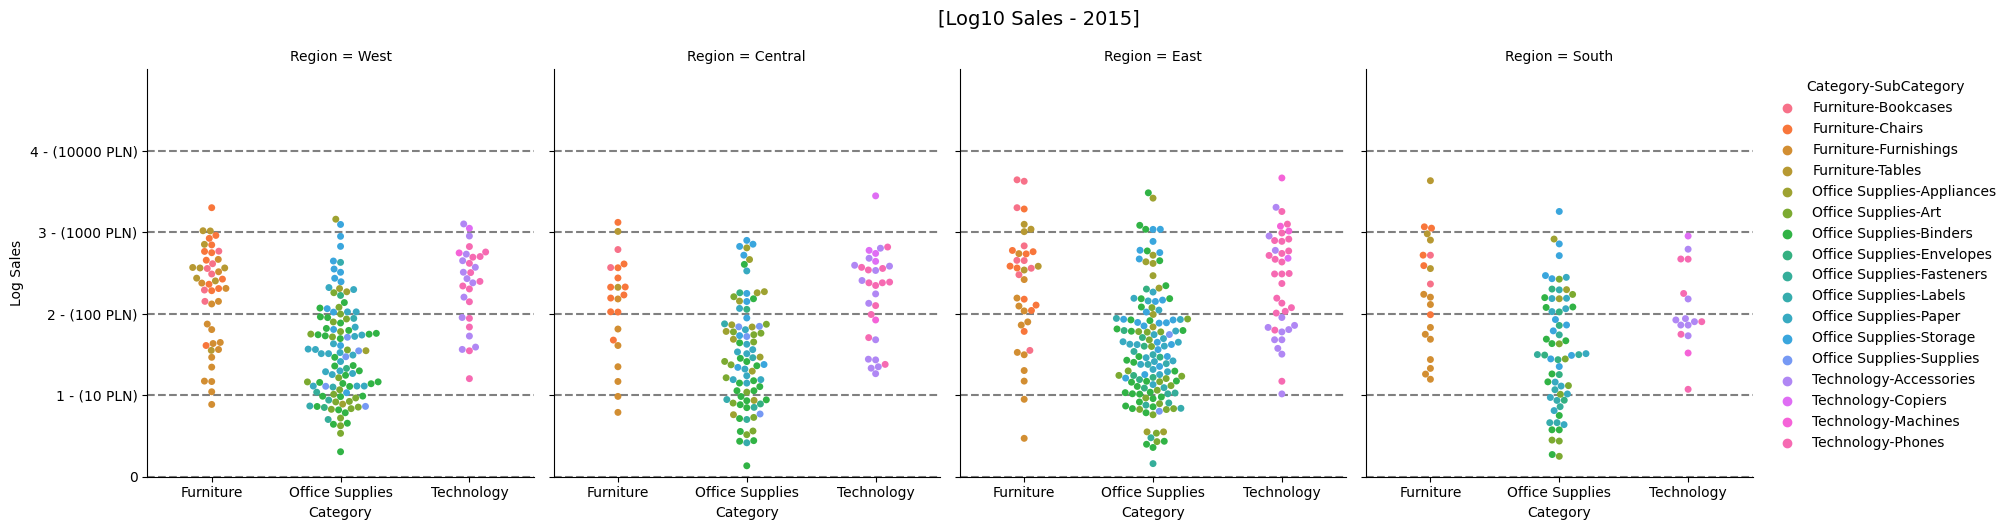

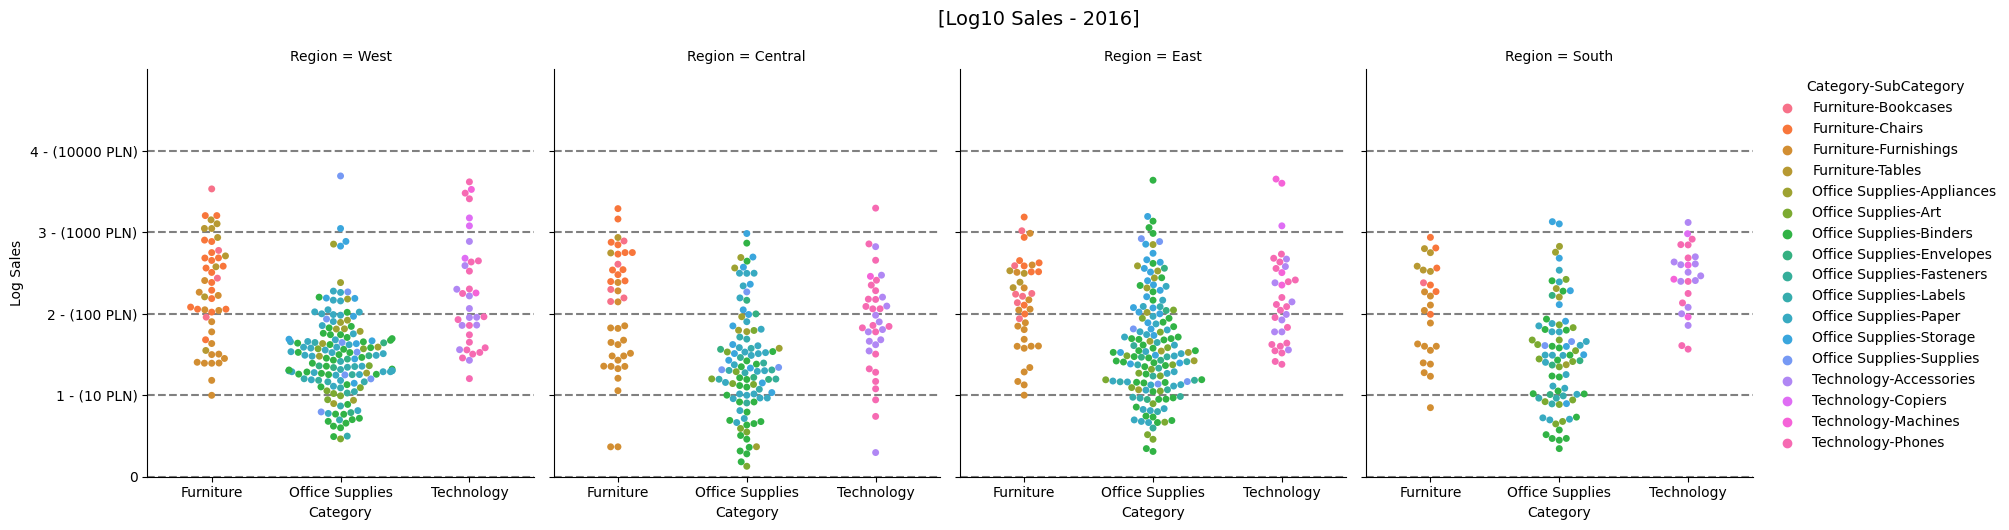

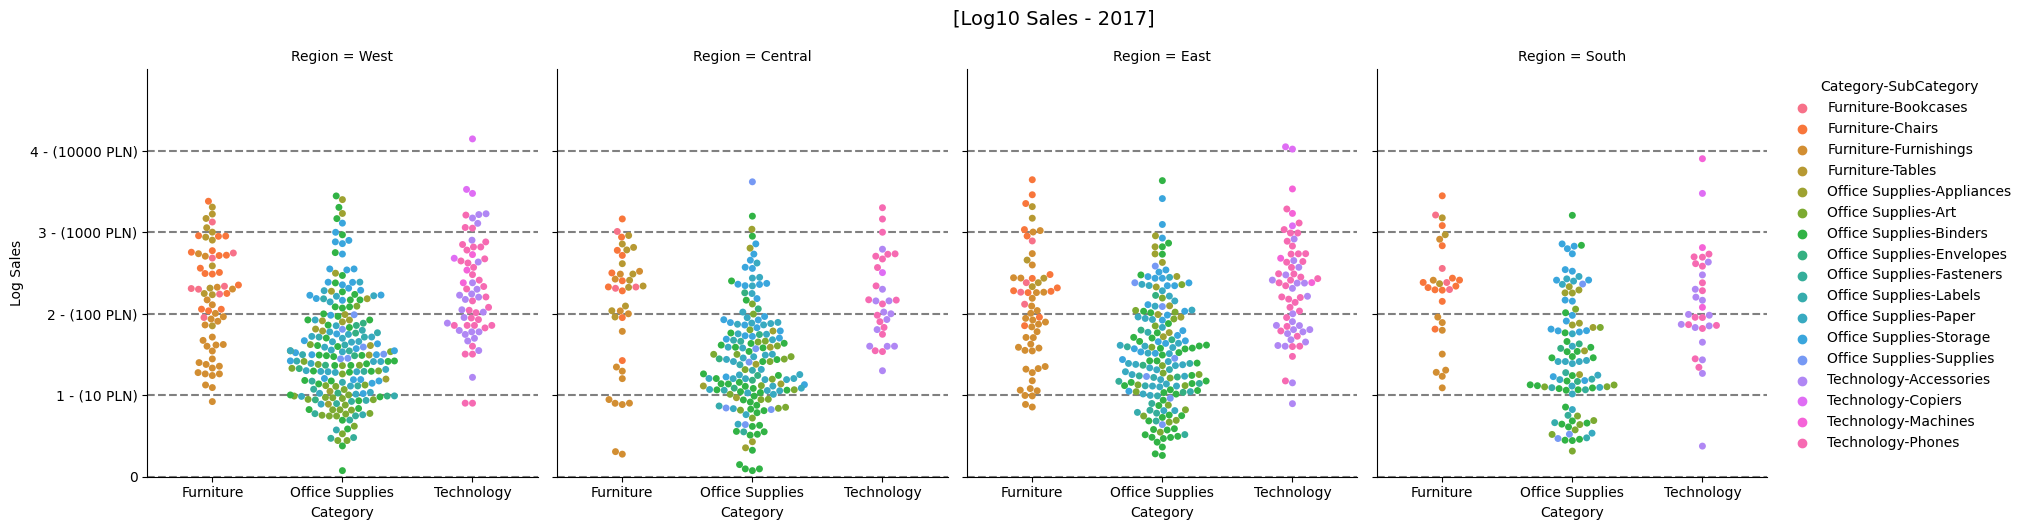

In [37]:
for i, v in enumerate(sorted(df["Order Year"].unique())):
    print(v)
    g = sns.catplot(
        data=df_sample[df_sample["Order Year"] == v], kind="swarm",
        x="Category", order=X_ORDER, y="Log Sales", hue="Category-SubCategory", hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85
    )
    g.set(ylim=(0, 5))
    g.fig.suptitle(f"[Log10 Sales - {v}]", fontsize=14, y=1.05)
    
    g.set(yticks=[0, 1, 2, 3, 4], yticklabels=["0", "1 - (10 PLN)", "2 - (100 PLN)", "3 - (1000 PLN)", "4 - (10000 PLN)"])
    # Move the legend outside the chart box
    # Add horizontal lines at each ytick
    for ax in g.axes.flat:
        yticks = ax.get_yticks()
        for ytick in yticks:
            ax.axhline(ytick, color='gray', linestyle='--')

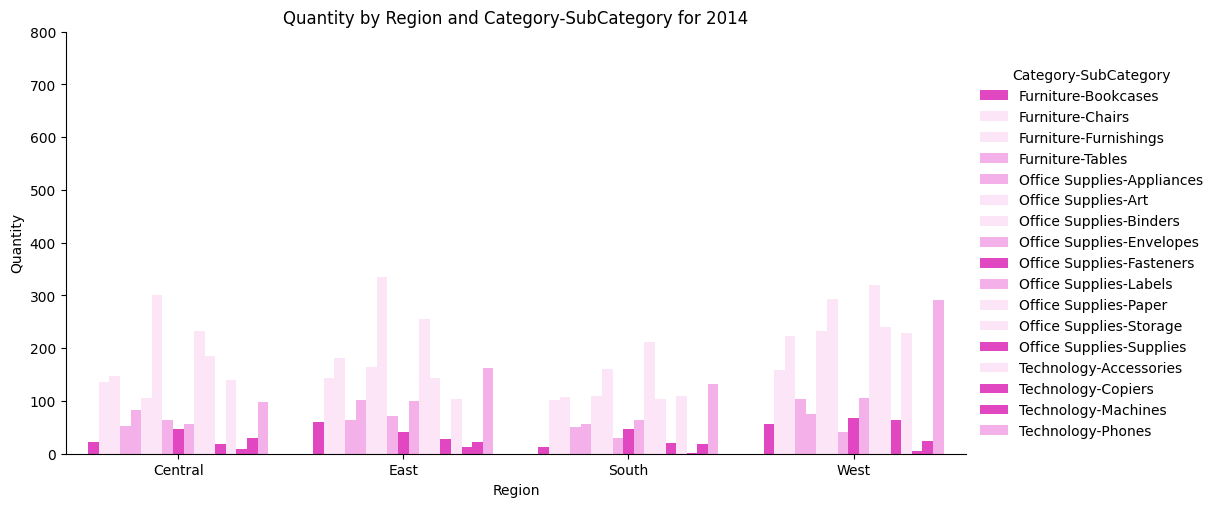

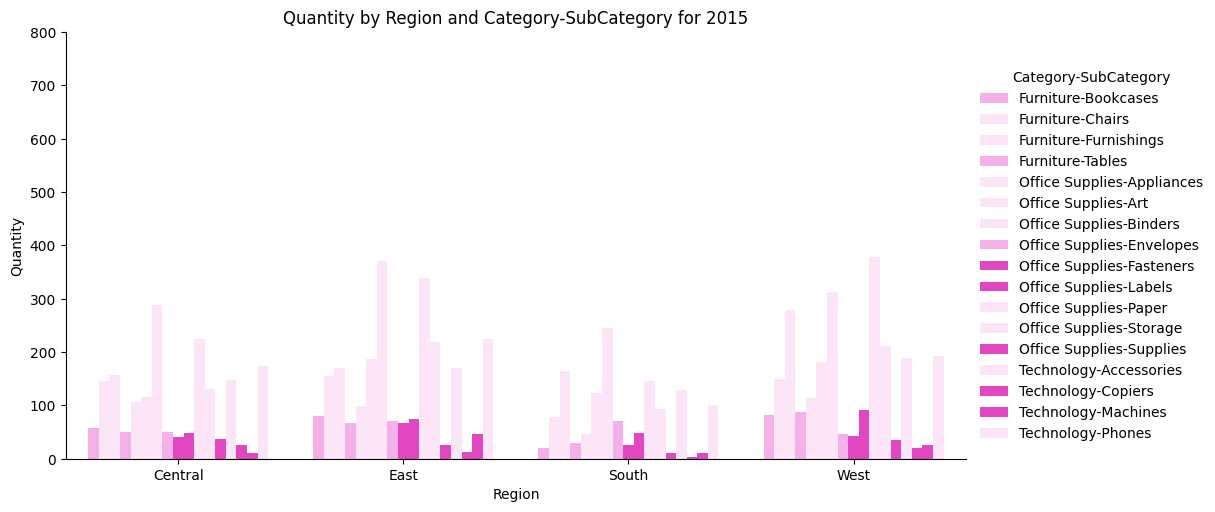

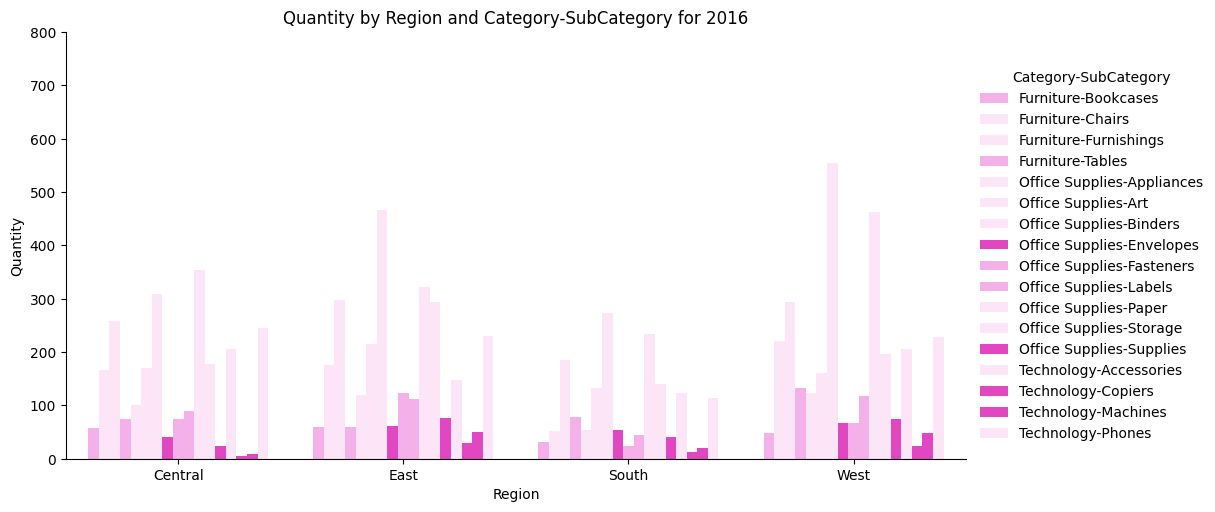

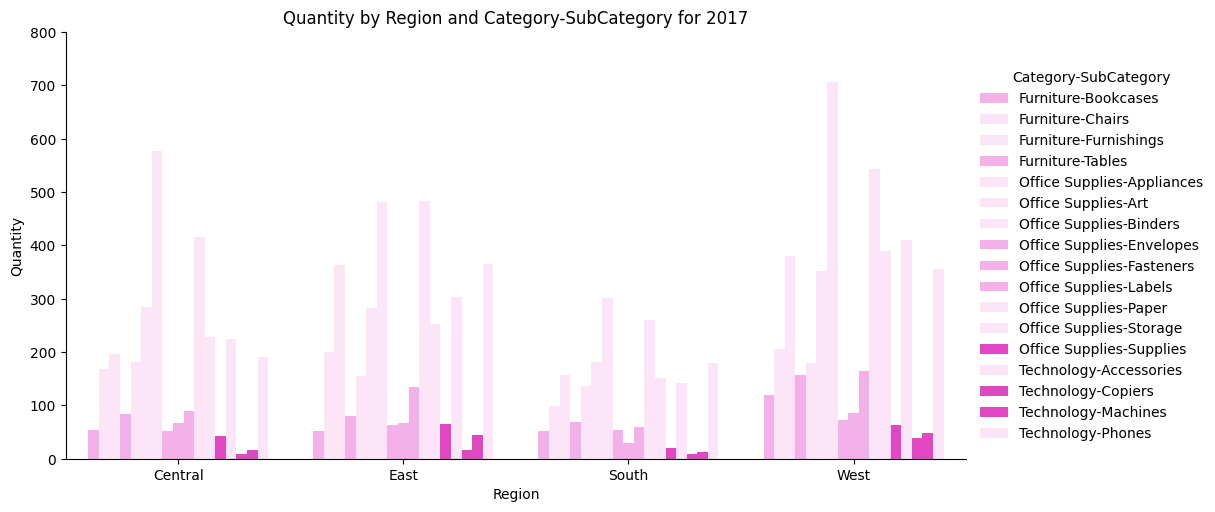

In [38]:
import seaborn as sns

# Define the function to generate a custom color palette
def color_palette(data, variable):
    colors = []
    for value in data[variable]:
        if value < 50:
            colors.append('#FA2DD0') # Light red
        elif value < 100:
            colors.append('#FFA5F0') # Medium red
        else:
            colors.append('#FFE1FA') # Dark red
    return colors

# Loop through the years and create the bar charts
for year in sorted(df['Order Year'].unique()):
    data = df[df['Order Year'] == year]
    pivot_table = data.groupby(['Region', 'Category-SubCategory']).agg({'Quantity': 'sum', 'Sales': 'sum'}).reset_index()

    # Set the color of the bars based on the Sales column
    my_palette = sns.color_palette(color_palette(pivot_table, 'Quantity'))

    # Plot Sales by Region and SubCategory
    g = sns.catplot(data=pivot_table, x='Region', y='Quantity', hue='Category-SubCategory', hue_order=HUE_ORDER, kind='bar', height=5, aspect=2, palette=my_palette)
    g.set(ylim=(0, 800))
    plt.title(f'Quantity by Region and Category-SubCategory for {year}')
    plt.show()


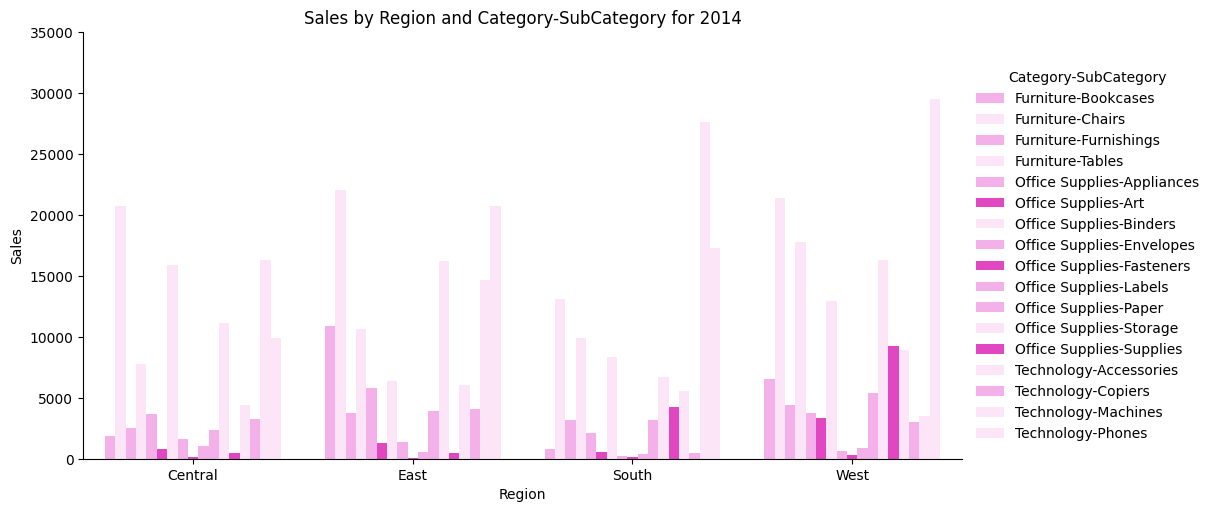

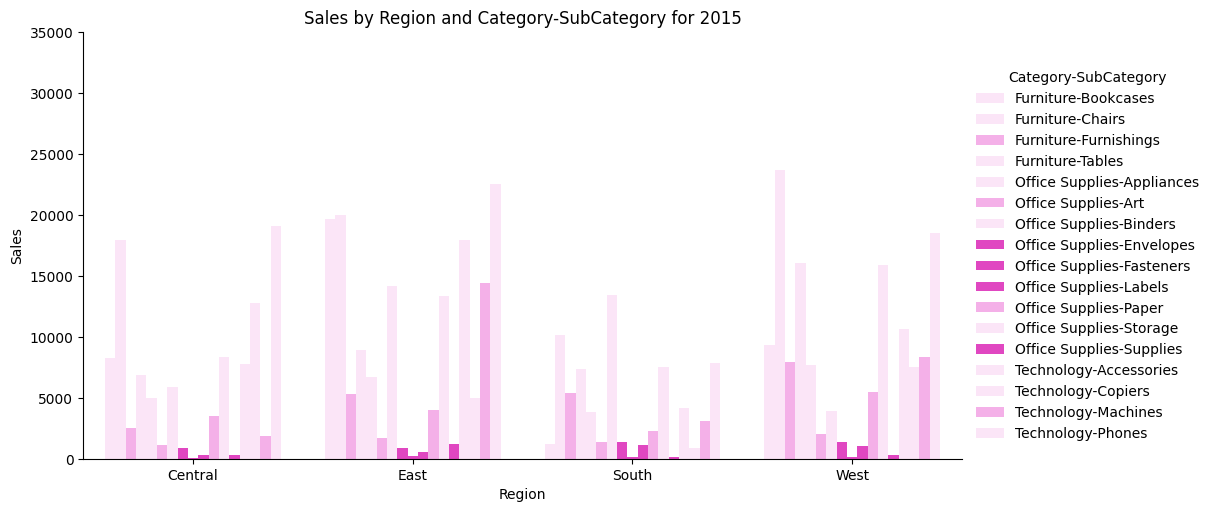

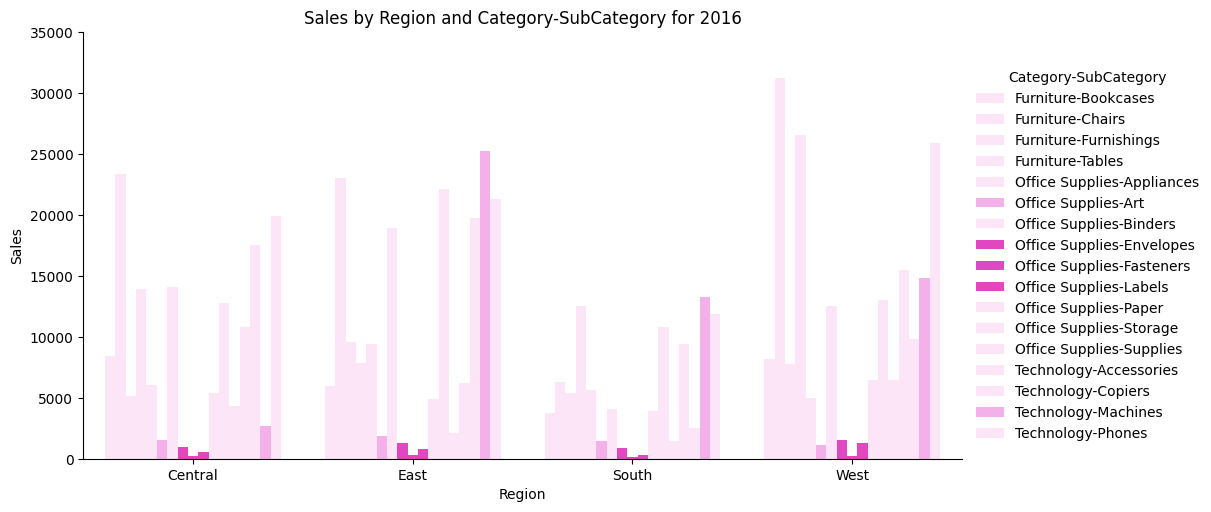

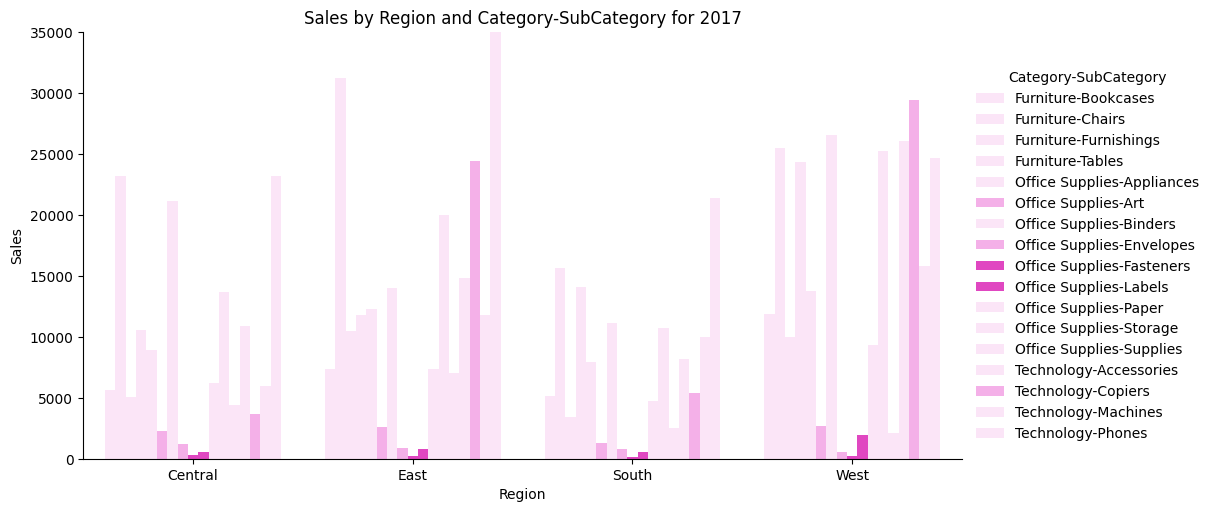

In [39]:
import seaborn as sns

# Define the function to generate a custom color palette
def color_palette(data, variable):
    colors = []
    for value in data[variable]:
        if value < 1000:
            colors.append('#FA2DD0') # Light red
        elif value < 4000:
            colors.append('#FFA5F0') # Medium red
        else:
            colors.append('#FFE1FA') # Dark red
    return colors

# Loop through the years and create the bar charts
for year in sorted(df['Order Year'].unique()):
    data = df[df['Order Year'] == year]
    pivot_table = data.groupby(['Region', 'Category-SubCategory']).agg({'Sales': 'sum'}).reset_index()

    # Set the color of the bars based on the Sales column
    my_palette = sns.color_palette(color_palette(pivot_table, 'Sales'))

    # Plot Sales by Region and SubCategory
    g = sns.catplot(data=pivot_table, x='Region', y='Sales', hue='Category-SubCategory', hue_order=HUE_ORDER, kind='bar', height=5, aspect=2, palette=my_palette)
    g.set(ylim=(0, 35000))
    plt.title(f'Sales by Region and Category-SubCategory for {year}')
    plt.show()


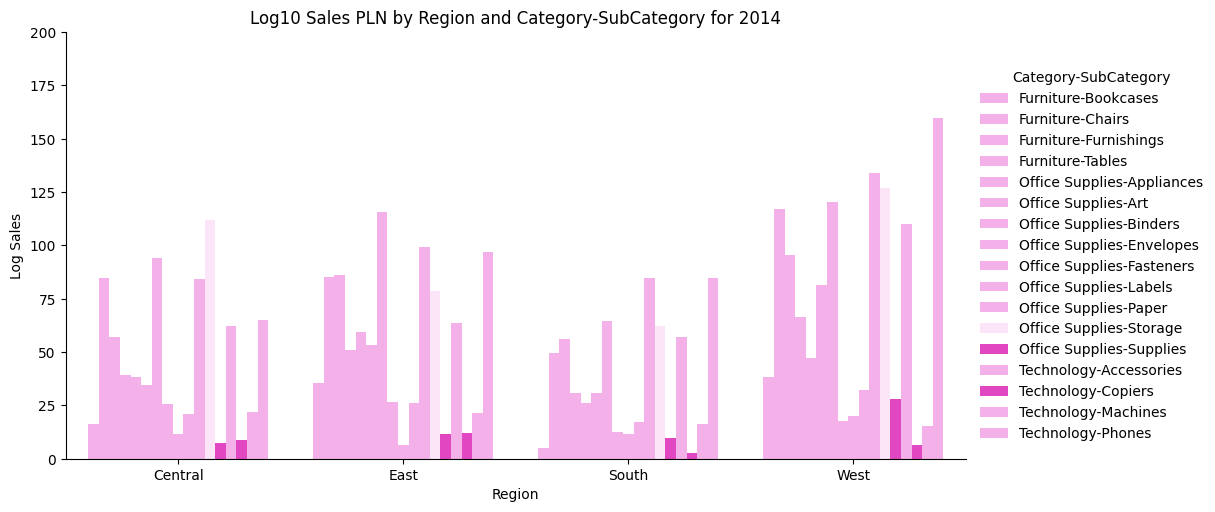

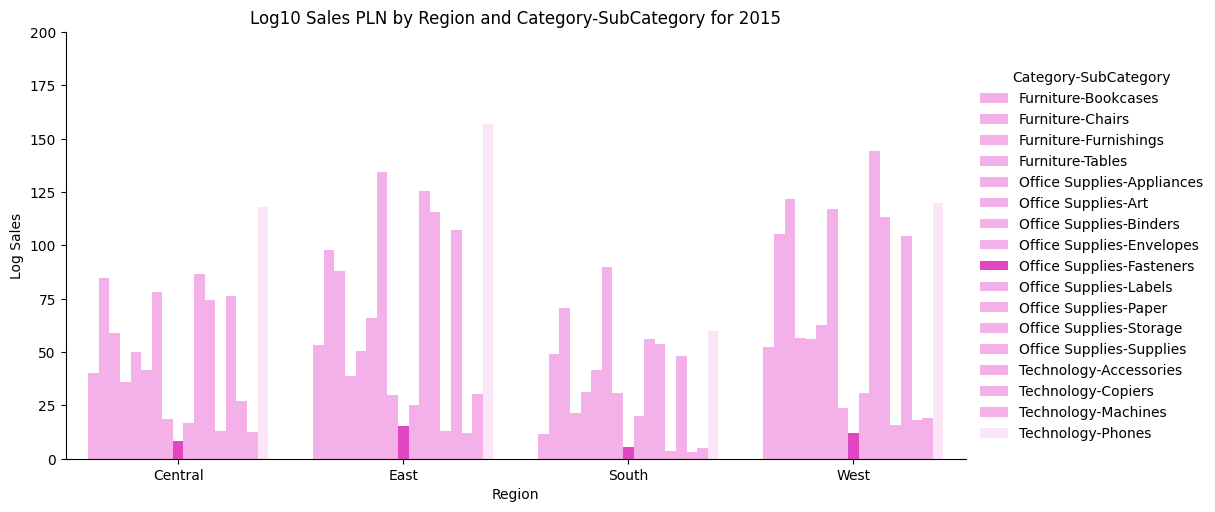

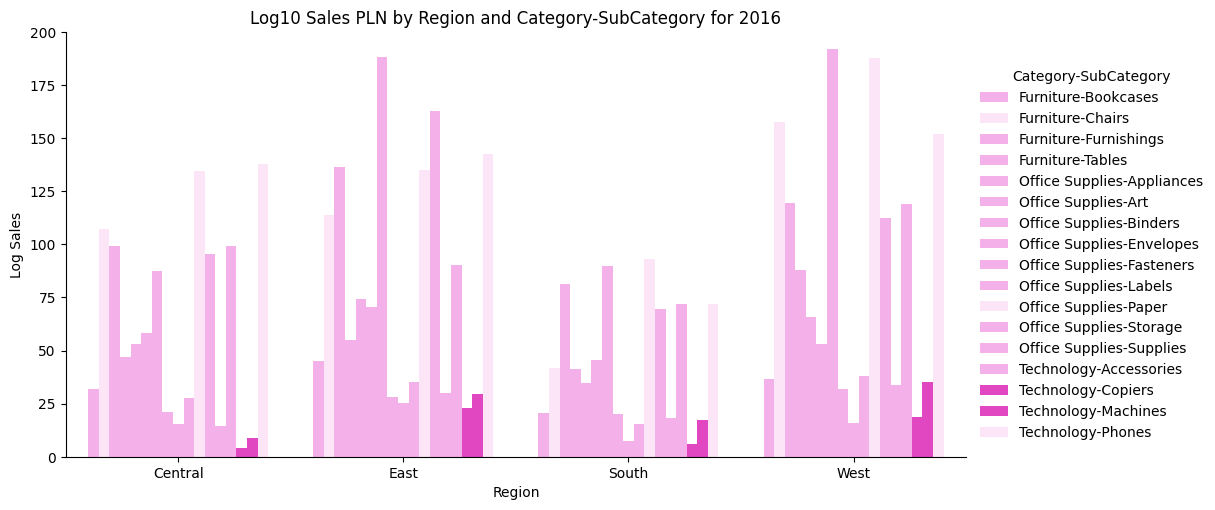

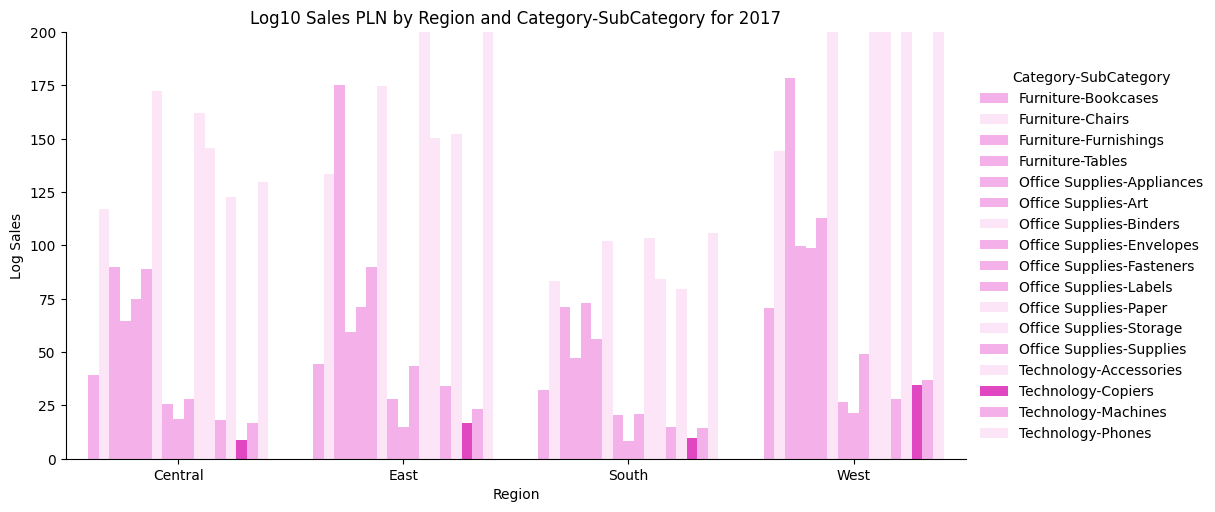

In [40]:
import seaborn as sns

# Define the function to generate a custom color palette
def color_palette(data, variable):
    colors = []
    for value in data[variable]:
        if value < 10:
            colors.append('#FA2DD0') # Light red
        elif value < 100:
            colors.append('#FFA5F0') # Medium red
        else:
            colors.append('#FFE1FA') # Dark red
    return colors

# Loop through the years and create the bar charts
for year in sorted(df['Order Year'].unique()):
    data = df[df['Order Year'] == year]
    pivot_table = data.groupby(['Region', 'Category-SubCategory']).agg({'Log Sales': 'sum'}).reset_index()

    # Set the color of the bars based on the Sales column
    my_palette = sns.color_palette(color_palette(pivot_table, 'Log Sales'))

    # Plot Sales by Region and SubCategory
    g = sns.catplot(data=pivot_table, x='Region', y='Log Sales', hue='Category-SubCategory', hue_order=HUE_ORDER, kind='bar', height=5, aspect=2, palette=my_palette)
    g.set(ylim=(0, 200))
    plt.title(f'Log10 Sales PLN by Region and Category-SubCategory for {year}')
    plt.show()


In [79]:
df_sample.index = pd.to_datetime(df_sample["Order Date"])

# Yearly Sales

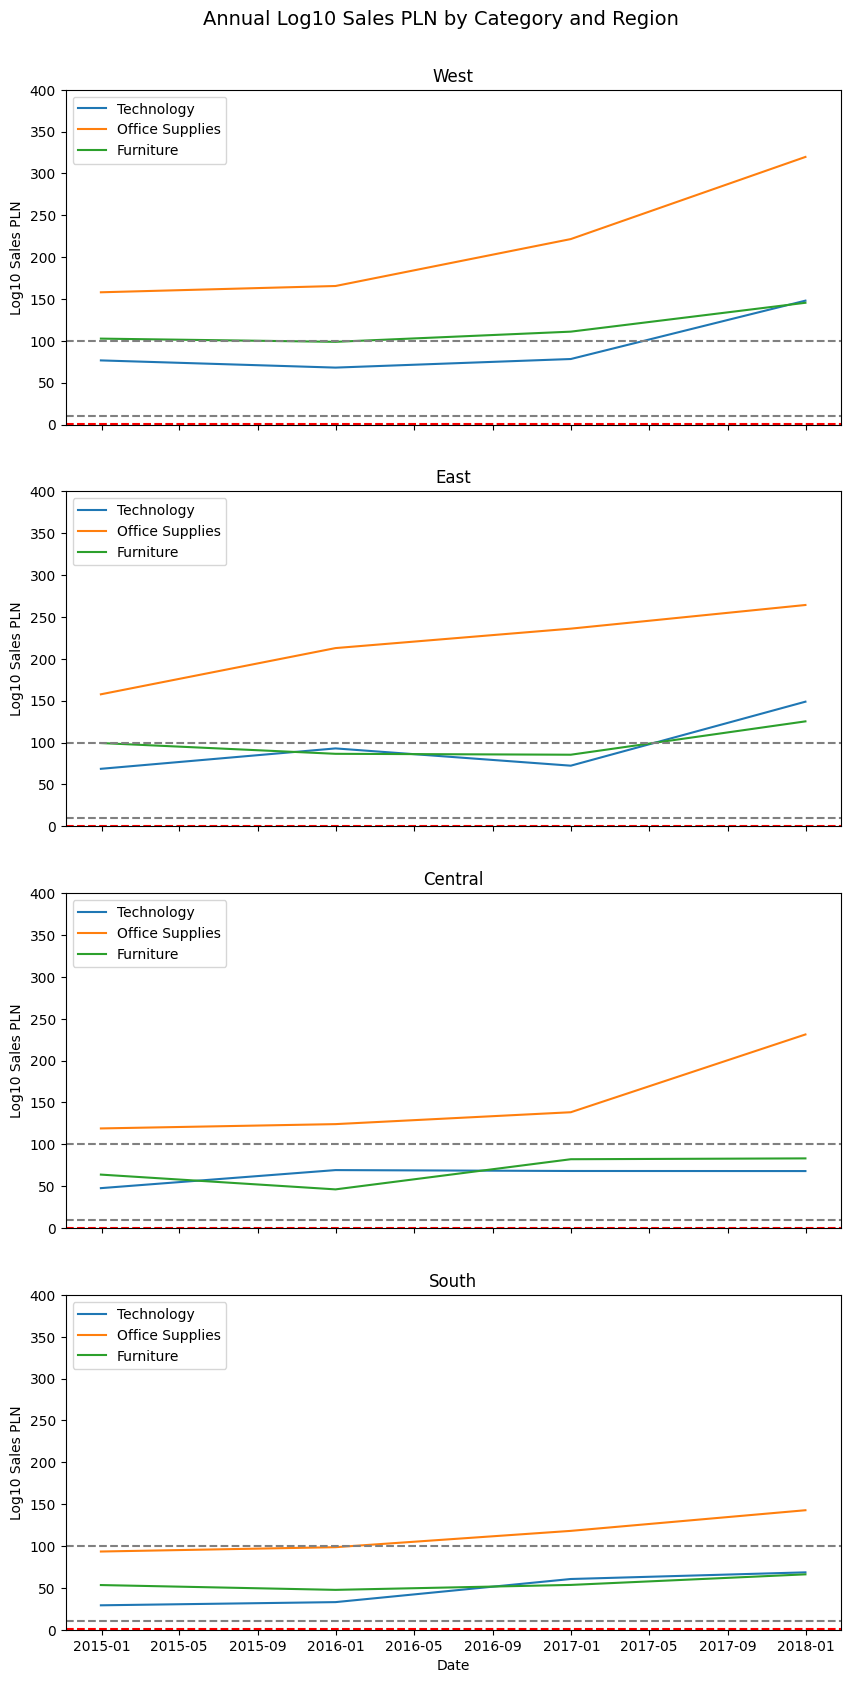

In [86]:
# Define the categories and regions
categories = df["Category"].unique()
regions = df["Region"].unique()

# Create subplots for each region
fig, axs = plt.subplots(len(regions), 1, figsize=(10, 20), sharex=True)

# Loop through each region
for i, region in enumerate(regions):
    # Select the data for the current region
    region_data = df_sample[df_sample["Region"] == region]
    # Loop through each category
    for j, category in enumerate(categories):
        # Select the data for the current category in the current region
        category_data = region_data[region_data["Category"] == category]
        # Convert the index to a datetime index
        category_data.index = pd.to_datetime(category_data.index)
        # Resample the data to annual intervals and calculate the sum
        annual_data = category_data.resample('A').sum()
        # Plot the annual sales line chart
        axs[i].plot(annual_data.index, annual_data['Log Sales'], label=category)
    # Set the title and y-axis label for the subplot
    axs[i].set_title(f"{region}")
    axs[i].set_ylabel("Log10 Sales PLN")
    axs[i].set(ylim=(0, 400))
    # Add horizontal lines at y=0.5 and y=10
    axs[i].axhline(y=0.5, color='r', linestyle='--')
    axs[i].axhline(y=10, color='gray', linestyle='--')
    axs[i].axhline(y=100, color='gray', linestyle='--')
    # Add the legend for the subplot
    axs[i].legend(loc="upper left")
# Set the x-axis label and title for the whole figure
plt.xlabel("Date")
fig.suptitle("Annual Log10 Sales PLN by Category and Region", fontsize=14, y=0.92)
# Show the plot
plt.show()


# Quarterly Sales

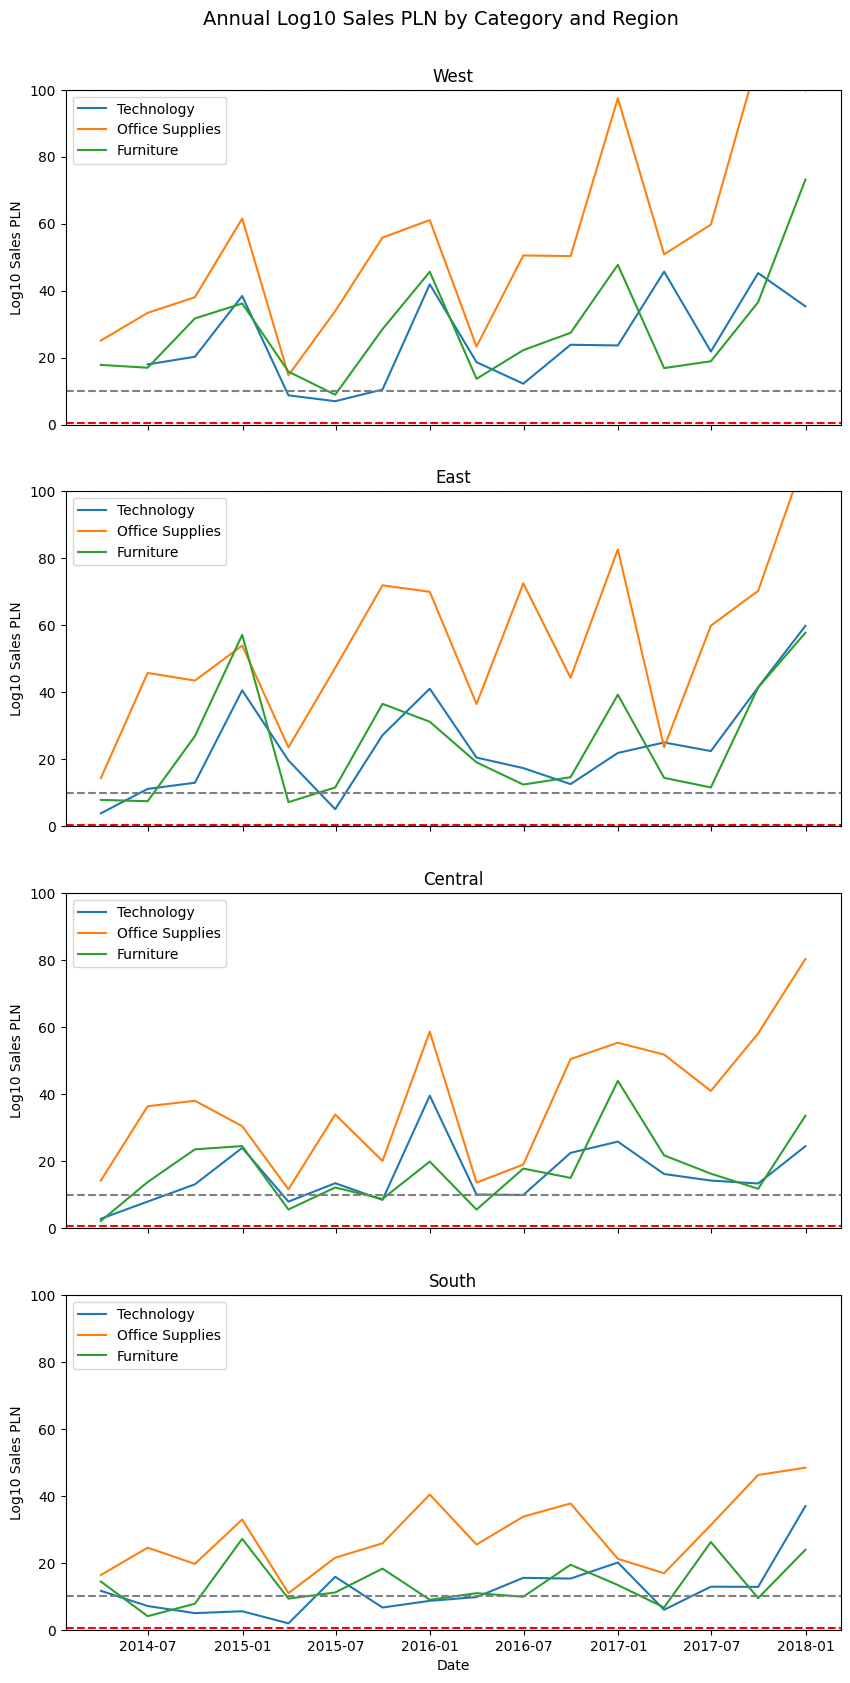

In [85]:
# Define the categories and regions
categories = df["Category"].unique()
regions = df["Region"].unique()

# Create subplots for each region
fig, axs = plt.subplots(len(regions), 1, figsize=(10, 20), sharex=True)

# Loop through each region
for i, region in enumerate(regions):
    # Select the data for the current region
    region_data = df_sample[df_sample["Region"] == region]
    # Loop through each category
    for j, category in enumerate(categories):
        # Select the data for the current category in the current region
        category_data = region_data[region_data["Category"] == category]
        # Convert the index to a datetime index
        category_data.index = pd.to_datetime(category_data.index)
        # Resample the data to annual intervals and calculate the sum
        annual_data = category_data.resample('Q').sum()
        # Plot the annual sales line chart
        axs[i].plot(annual_data.index, annual_data['Log Sales'], label=category)
    # Set the title and y-axis label for the subplot
    axs[i].set_title(f"{region}")
    axs[i].set_ylabel("Log10 Sales PLN")
    axs[i].set(ylim=(0, 100))
    # Add horizontal lines at y=0.5 and y=10
    axs[i].axhline(y=0.5, color='r', linestyle='--')
    axs[i].axhline(y=10, color='gray', linestyle='--')
    axs[i].axhline(y=100, color='gray', linestyle='--')
    # Add the legend for the subplot
    axs[i].legend(loc="upper left")
# Set the x-axis label and title for the whole figure
plt.xlabel("Date")
fig.suptitle("Annual Log10 Sales PLN by Category and Region", fontsize=14, y=0.92)
# Show the plot
plt.show()


# Monthly Sales

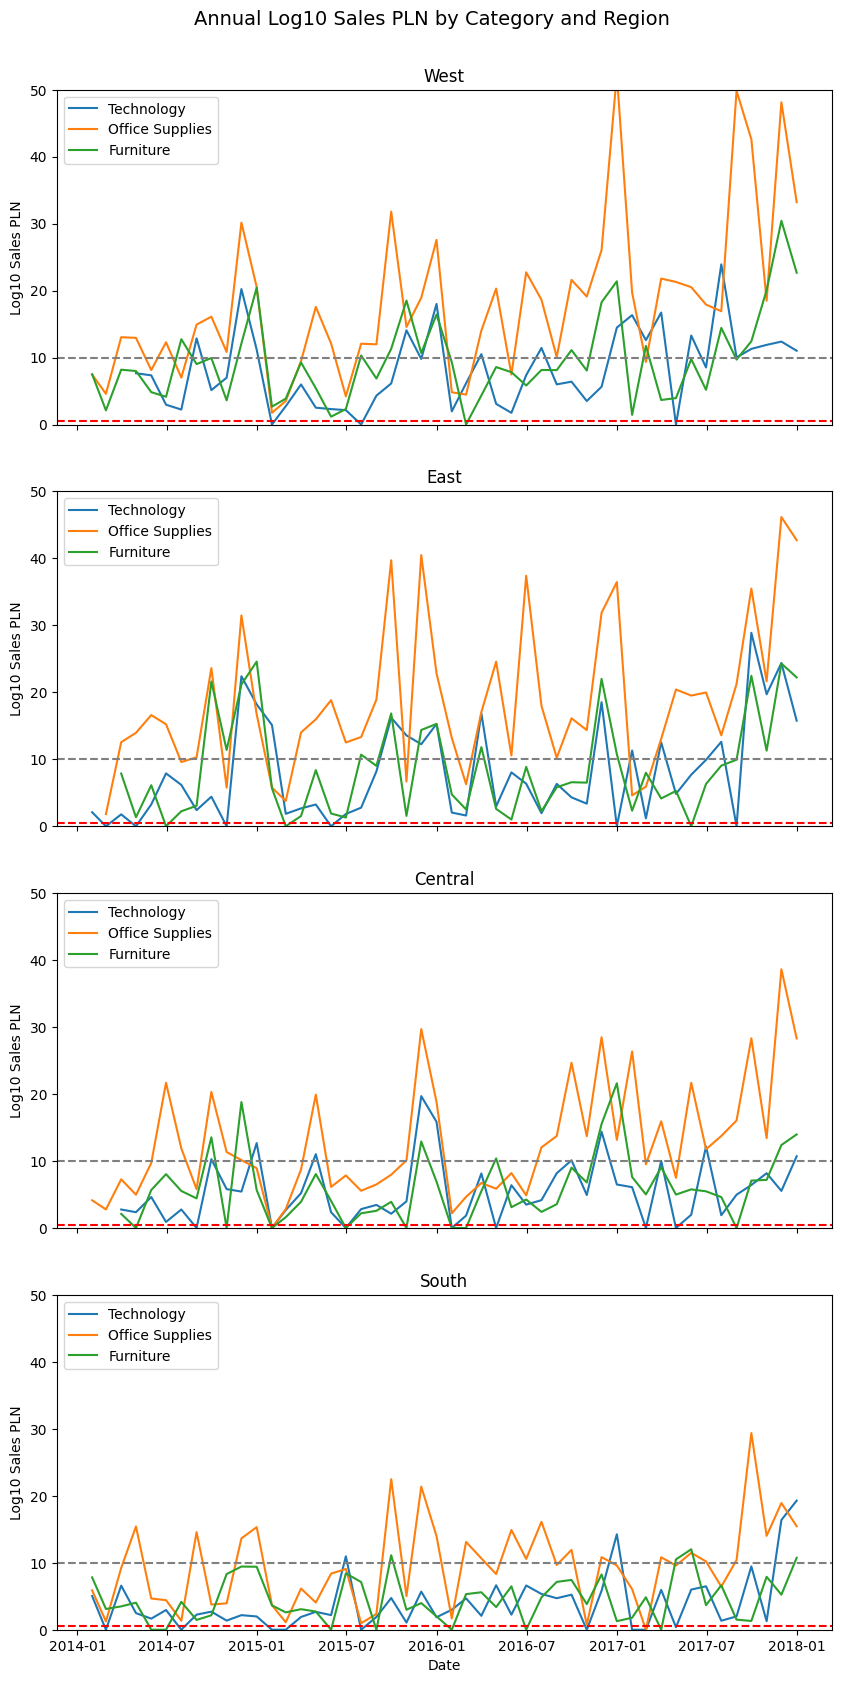

In [84]:
# Define the categories and regions
categories = df["Category"].unique()
regions = df["Region"].unique()

# Create subplots for each region
fig, axs = plt.subplots(len(regions), 1, figsize=(10, 20), sharex=True)

# Loop through each region
for i, region in enumerate(regions):
    # Select the data for the current region
    region_data = df_sample[df_sample["Region"] == region]
    # Loop through each category
    for j, category in enumerate(categories):
        # Select the data for the current category in the current region
        category_data = region_data[region_data["Category"] == category]
        # Convert the index to a datetime index
        category_data.index = pd.to_datetime(category_data.index)
        # Resample the data to annual intervals and calculate the sum
        annual_data = category_data.resample('M').sum()
        # Plot the annual sales line chart
        axs[i].plot(annual_data.index, annual_data['Log Sales'], label=category)
    # Set the title and y-axis label for the subplot
    axs[i].set_title(f"{region}")
    axs[i].set_ylabel("Log10 Sales PLN")
    axs[i].set(ylim=(0, 50))
    # Add horizontal lines at y=0.5 and y=10
    axs[i].axhline(y=0.5, color='r', linestyle='--')
    axs[i].axhline(y=10, color='gray', linestyle='--')
    axs[i].axhline(y=100, color='gray', linestyle='--')
    # Add the legend for the subplot
    axs[i].legend(loc="upper left")
# Set the x-axis label and title for the whole figure
plt.xlabel("Date")
fig.suptitle("Annual Log10 Sales PLN by Category and Region", fontsize=14, y=0.92)
# Show the plot
plt.show()


# SQL

In [ ]:
conn = connect(':memory:')
df.to_sql('data', conn)

# General view

In [ ]:
agg_data = pd.read_sql(
"""
    SELECT
        "Order Year"
        ,"Order Month"
        ,Category
        ,SUM("Quantity") AS Quantity
        ,SUM("Sales") AS Sales
        ,SUM("Log Sales") AS LogSales
        ,SUM("Profit") AS Profit
    FROM data
    GROUP BY
        "Order Year"
        ,"Order Month"
        ,Category
    
""",
conn
)

In [ ]:
# furniture_pivot = pd.pivot_table(furniture, values='Count', index=['Order Year', 'Category'],
#                           columns=['Order Month'], aggfunc=sum, fill_value=0)

In [ ]:
# furniture_pivot

In [ ]:
# # iterate over the multi-index
# for index, group in furniture_pivot.groupby(level=['Order Year', 'Category']):
# #     print('Order Year:', index[0])
#     print('Category:', index[1])
# #     print(group)

In [ ]:
agg_data_pivot = pd.pivot_table(agg_data, values='Quantity', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

In [ ]:
agg_data_pivot

In [ ]:
ax = sns.lineplot(data=agg_data_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Quantity by Each Month through all Years")
ax.set_yticks(list(range(0, 500, 100)))
for y in range(0, 500, 100):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()

In [ ]:
agg_data_pivot = pd.pivot_table(agg_data, values='Sales', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

In [ ]:
ax = sns.lineplot(data=agg_data_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Sales PLN by Each Month through all Years")
ax.set_yticks(list(range(0, 40000, 5000)))
for y in range(0, 40000, 5000):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()

In [ ]:
agg_data_pivot = pd.pivot_table(agg_data, values='LogSales', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

In [ ]:
ax = sns.lineplot(data=agg_data_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Log10 Sales PLN by Each Month through all Years")
ax.set_yticks(list(range(0, 250, 10)))
for y in range(0, 250, 10):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()

# Technology

In [ ]:
technology = pd.read_sql(
"""
    SELECT
        "Order Year"
        ,"Order Month"
        ,Category
        ,SUM("Quantity") AS Quantity
        ,SUM("Sales") AS Sales
        ,SUM("Log Sales") AS LogSales
        ,SUM("Profit") AS Profit
    FROM data
    WHERE
        Category IN ('Technology')
    GROUP BY
        "Order Year"
        ,"Order Month"
        ,Category
    
""",
conn
)

In [ ]:
technology_pivot = pd.pivot_table(technology, values='Quantity', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

In [ ]:
technology_pivot

In [ ]:
ax = sns.lineplot(data=technology_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Technology Quantity by Each Month through all Years")
ax.set_yticks(list(range(0, 500, 100)))
for y in range(0, 500, 100):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()

In [ ]:
technology_pivot = pd.pivot_table(technology, values='Sales', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

In [ ]:
ax = sns.lineplot(data=technology_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Technology Sales by Each Month through all Years")
ax.set_yticks(list(range(0, 50000, 5000)))
for y in range(0, 50000, 5000):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()

In [ ]:
technology_pivot = pd.pivot_table(technology, values='LogSales', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

In [ ]:
ax = sns.lineplot(data=technology_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Technology Profit by Each Month through all Years")
ax.set_yticks(list(range(0, 250, 100)))
for y in range(0, 250, 100):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()

# Office supplies

In [ ]:
office_supplies = pd.read_sql(
"""
    SELECT
        "Order Year"
        ,"Order Month"
        ,Category
        ,SUM("Quantity") AS Quantity
        ,SUM("Sales") AS Sales
        ,SUM("Log Sales") AS LogSales
        ,SUM("Profit") AS Profit
    FROM data
    WHERE
        Category IN ('Office Supplies')
    GROUP BY
        "Order Year"
        ,"Order Month"
        ,Category
    
""",
conn
)

In [ ]:
office_supplies_pivot = pd.pivot_table(office_supplies, values='Quantity', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

In [ ]:
ax = sns.lineplot(data=office_supplies_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Office supplies Count by Each Month through all Years")
ax.set_yticks(list(range(0, 350, 25)))
for y in range(0, 350, 25):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()

In [ ]:
office_supplies_pivot = pd.pivot_table(office_supplies, values='Sales', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

In [ ]:
ax = sns.lineplot(data=office_supplies_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Office supplies Sales by Each Month through all Years")
ax.set_yticks(list(range(0, 50000, 5000)))
for y in range(0, 50000, 5000):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()

In [ ]:
office_supplies_pivot = pd.pivot_table(office_supplies, values='LogSales', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

In [ ]:
ax = sns.lineplot(data=office_supplies_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Office supplies Profit by Each Month through all Years")
ax.set_yticks(list(range(0, 1000, 100)))
for y in range(0, 1000, 100):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()